This notebook contains all our scripts for the poster presentation at the NeuroAI Conference.

### Imports and Data Loading

In [13]:
# Edgar new data Jan 2024

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
import pathlib
from pathlib import Path

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from models import *
from utils import *

from loguru import logger
from sklearn.linear_model import TweedieRegressor
from preprocessing import *

seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    print(torch.cuda.get_device_name())

NVIDIA GeForce GTX 1080


In [14]:
# stim_times: index at which stimulation occurred 
# ephys_array: array of Neurons_x_Samples (units = # of spikes) 
# img_array:  array of Neurons_x_Samples (units = dFF)
# stim_ID: Identity of a given stim (a = forward, b = reverse, c = random) 
# each index is 33ms

'''
3s after each stimulation, 100ms time bins
input summed dF/F
spikes 100ms

# 1 how well can we predict endogenous to endogenous: 3s after onset, -100 to +100 ms bins spikes as output.
    potential issue: Ca2+ decay issue! Temporal decorrelation by binarising at each onset time?
# 2 endogenous to stimulations: 30ms bins.

Off-target problems?
Recurrent networks?
'''
parent_path = Path('./data/biological/JAN23')
save_path = Path('./save/trained_models/JAN23')

stim_time = np.load(parent_path / 'stim_times.npy')         # (300,)
ephys_array = np.load(parent_path / 'ephys_array.npy')      # (77, 94357)
img_array = np.load(parent_path / 'img_array.npy')          # (384, 94357)
stim_id = np.load(parent_path / 'stim_ID.npy')              # (300,)

n_neurons, total_time = ephys_array.shape
n_stims = stim_time.shape[0]

2024-03-11 13:27:29.444 | INFO     | preprocessing:convolve_spikes:26 - Detected Ephys file with 77 neurons and 94357 bins.
2024-03-11 13:27:29.583 | INFO     | preprocessing:convolve_spikes:51 - Produced convolved rates at sigma=0.1 with 77 neurons and 94357 bins.


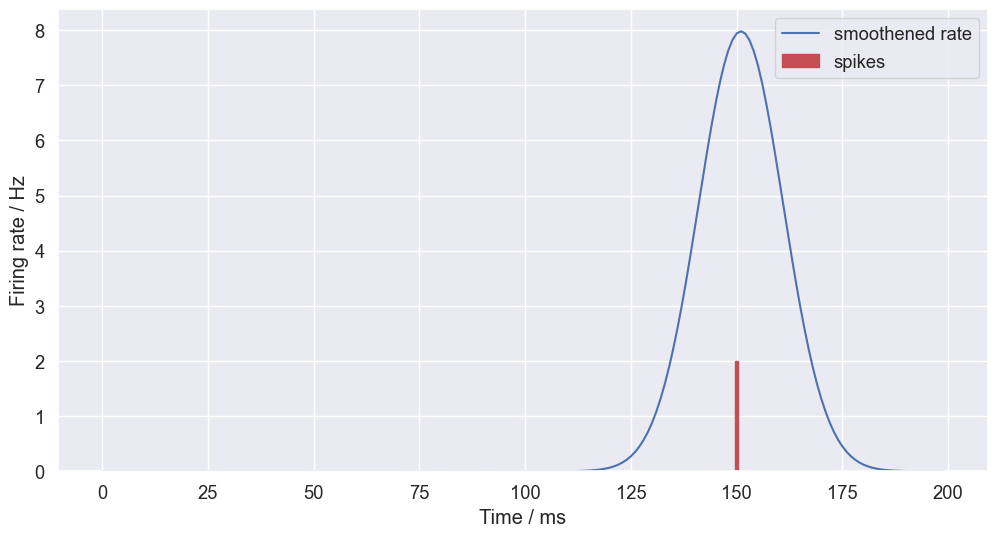

In [15]:
spks_stim_rates, n_output_neurons, n_bins = convolve_spikes(ephys_array)
plot_convolution_example(spks_stim_rates, ephys_array)
input_dim = img_array.shape[0]
assert n_bins == img_array.shape[1]

### Data Pre-processing
Process all input (GCaMP) data into independent tensors of length 15 (time steps) x 387 (input neurons) <br>
Process all output (EPhys) data into independent vectors of length 1 (time step) x 77 (output neurons)
The offset between input and output is -4 steps, found earlier by GLM. This is because there is a time delay in fluorescence decay.

In [16]:
inputs, targets, non_stim_vecs_idx, stim_vecs_idx = preprocess_dff_rate_pairs(img_array,
                                                                              spks_stim_rates,
                                                                              has_stim=True,
                                                                              stim_time=stim_time,
                                                                              stim_ID=stim_id,
                                                                              cutoff_size=1,
                                                                              offset=-3,
                                                                              tsteps=15)
sampled_non_stim_vecs = sample_non_stim_vecs(non_stim_vecs_idx, cutoff_size=1, n=200, seed=seed)
test_set_idx = np.concatenate([stim_vecs_idx, sampled_non_stim_vecs])
X, Y = inputs[non_stim_vecs_idx], targets[non_stim_vecs_idx]
X_test, Y_test = inputs[test_set_idx], targets[test_set_idx]

In [17]:
n_non_stim = len(Y)
valid_idx = np.random.choice(np.arange(len(Y)), int(n_non_stim * 0.10))
train_idx = np.array(list((set(np.arange(len(Y))) - set(valid_idx))))
LS_neuron_idx = np.arange(13)

X_train, Y_train = inputs[non_stim_vecs_idx], targets[non_stim_vecs_idx]
X_test, Y_test = inputs[test_set_idx], targets[test_set_idx]

forward_mse_idx = list(np.nonzero(np.array(stim_id) == 'a')[0])
backward_mse_idx = list(np.nonzero(np.array(stim_id) == 'b')[0])
random_mse_idx = list(np.nonzero(np.array(stim_id) == 'c')[0])
non_stim_mse_idx = np.arange(len(stim_id), Y_test.shape[0])

assert len(np.intersect1d(forward_mse_idx, backward_mse_idx)) == 0
assert len(np.intersect1d(backward_mse_idx, random_mse_idx)) == 0
assert len(np.intersect1d(random_mse_idx, non_stim_mse_idx)) == 0
assert len(np.intersect1d(non_stim_mse_idx, forward_mse_idx)) == 0

X_train, Y_train_LS = X[train_idx, ...], Y[train_idx,:,:][..., LS_neuron_idx]
Y_test_LS = Y_test[..., LS_neuron_idx]
X_valid, Y_valid_LS = X[valid_idx, ...], Y[valid_idx,:,:][..., LS_neuron_idx]

### Train for LS neurons only

In [18]:
# first 13 neurons are lateral septal according to Edgar
output_dim = Y_train_LS.shape[-1]

batch_size = 4096
train_dataset = BNN_Dataset(X_train, Y_train_LS)
train_dataloader_LS = DataLoader(train_dataset, batch_size=batch_size, drop_last=False, shuffle=True)
test_dataset = BNN_Dataset(X_test, Y_test_LS)
test_dataloader_LS = DataLoader(test_dataset, batch_size=len(test_dataset), drop_last=False, shuffle=False)
valid_dataset = BNN_Dataset(X_valid, Y_valid_LS)
valid_dataloader_LS = DataLoader(valid_dataset, batch_size=len(valid_dataset), drop_last=False, shuffle=False)

del train_dataset, test_dataset, valid_dataset

# fit GLM with identity link function
X_train_np = X_train.cpu().numpy().reshape(X_train.shape[0],-1)
Y_train_LS_np = Y_train_LS.cpu().numpy().reshape(Y_train_LS.shape[0],-1) + 1e-6 # numerical stability

X_test_np = X_test.cpu().numpy().reshape(X_test.shape[0],-1)
Y_test_LS_np = Y_test_LS.cpu().numpy().reshape(Y_test_LS.shape[0],-1) + 1e-6 # numerical stability

Hyperparameter optimisation for transformer using Bayes Opt: <br>
<ol>
  <li>d_model (int) – the number of expected features in the input (required).</li>
  <li>nhead (int) – the number of heads in the multiheadattention models (required).</li>
  <li>hidden_dim (int) – the dimension of the feedforward network model (default=2048).</li>
  <li>num_layers – the number of sub-encoder-layers in the encoder (required).</li>
</ol>

In [8]:
_run = True
from bayes_opt import BayesianOptimization
from models import TransformerOneStep
from train import train_transformer, eval_transformer
from utils import count_parameters

LS_param_counts = []

import gc
def black_box_function(d_model, num_heads, hidden_dim, n_layers, seed=seed):
    gc.collect()
    torch.cuda.empty_cache()
    
    seed = 123
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    hidden_dim, d_model, n_layers, num_heads = int(hidden_dim), int(d_model), int(n_layers), int(num_heads)
    d_model = int(int(d_model/num_heads)*num_heads) # d_model must be multiples of n_heads
    if d_model %2 != 0:
        d_model += num_heads
        
    DNN = TransformerOneStep(input_dim,
                d_model=d_model,
                num_heads=num_heads,
                hidden_dim=hidden_dim,
                output_dim=output_dim,
                n_encoder_layers=n_layers,
                device=device, 
                max_len=30,
                dropout=0.2,
                use_mask=False,   # not autoregressive task
                pos_output=True,
                bin_output=False,
                softmax_output=False).to(device)
    
    optimiser = torch.optim.Adam(DNN.parameters(), lr=1e-3)
    criterion = nn.MSELoss()
    
    # scheduler = torch.optim.lr_scheduler.ExponentialLR(optimiser, gamma=0.99)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, mode='min', factor=0.5, patience=10, threshold=0.01)

    return_dict = train_transformer(
        model=DNN,
        train_loader=train_dataloader_LS, test_loader=valid_dataloader_LS, # use valid loader here
        optimiser=optimiser, criterion=criterion, num_epochs=250,
        verbose=False, force_stop=False, scheduler=scheduler)

    LS_param_counts.append([min(return_dict['eval_losses']), count_parameters(DNN), d_model, num_heads, hidden_dim, n_layers])
    valid_loss = -min(return_dict['eval_losses'])   
    del DNN, return_dict
    gc.collect()
    torch.cuda.empty_cache()
    return valid_loss

def run_bayes_opt(pbounds, init_points=200, n_iter=200):
    optimizer = BayesianOptimization(f=black_box_function, pbounds=pbounds, random_state=123)
    optimizer.maximize(init_points=init_points, n_iter=n_iter)

if _run:
    run_bayes_opt(pbounds = {'d_model':(100, 2000), 'num_heads':(1, 30), 'hidden_dim':(100, 1000), 'n_layers':(1, 5)}, init_points=200, n_iter=200)
    np.save(f'./data/trained_models/JAN23-stim-LS-param_counts.npy', np.array(LS_param_counts))

|   iter    |  target   |  d_model  | hidden... | n_layers  | num_heads |
-------------------------------------------------------------------------


c:\Users\Dan\anaconda3\envs\torch-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
  0%|          | 1/250 [00:01<07:59,  1.92s/it]


KeyboardInterrupt: 

Train transformer

In [19]:
# TRANSFORMER
# |   iter    |  target   |  d_model  | hidden... | n_layers  | num_heads |
# | 5         | -172.0    | 446.7     | 257.9     | 3.126     | 16.42     |


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from models import TransformerOneStep
d_model = 432
num_heads = 16
hidden_dim = 446
n_layers = 3

d_model = int(int(d_model/num_heads)*num_heads) # d_model must be multiples of n_heads
if d_model % 2 != 0:
    d_model += num_heads

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from models import TransformerOneStep

DNN_LS = TransformerOneStep(input_dim,
                d_model=d_model,
                num_heads=num_heads,
                hidden_dim=hidden_dim,
                output_dim=output_dim,
                n_encoder_layers=n_layers,
                device=device, 
                max_len=30,
                dropout=0.2,
                decoder='linear',
                decoder_hidden_dim=None,
                use_mask=True,
                pos_output=True,
                bin_output=False,
                softmax_output=False).to(device)

c:\Users\Dan\anaconda3\envs\torch-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [20]:
# import wandb
# wandb.login()
# wandb.init(project='approx_brain')
from train import train_transformer, eval_transformer


return_dict = None # intialise as None
n_cycles = 25
num_epochs = 500

for _ in range(n_cycles):
    optimiser = torch.optim.Adam(DNN_LS.parameters(), lr=1e-3, weight_decay=1e-5)
    criterion = nn.MSELoss(reduction='none')
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, 
                                                        mode='min', 
                                                        factor=0.5, 
                                                        patience=10, 
                                                        threshold=0.01)

    return_dict = train_transformer(
                model=DNN_LS,
                train_loader=train_dataloader_LS,
                test_loader=test_dataloader_LS,
                optimiser=optimiser,
                criterion=criterion,
                num_epochs=num_epochs,
                verbose=True,
                batch_first=True,
                scheduler=scheduler,
                use_wandb=False,
                stim_type_indices=
                [forward_mse_idx, backward_mse_idx, random_mse_idx, non_stim_mse_idx],
                prev_return_dict=return_dict)

Initial eval loss: 1282.9325832273378


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 1/500 [00:00<06:44,  1.23it/s]

Epoch 1: training loss 1197.6281127929688, eval loss 1127.000935730736. Time elapsed: 0 h 0 m 0 s.


  5%|▌         | 26/500 [00:18<05:35,  1.41it/s]

Epoch 26: training loss 474.4408721923828, eval loss 459.73703125813137. Time elapsed: 0 h 0 m 18 s.


 10%|█         | 51/500 [00:35<05:12,  1.44it/s]

Epoch 51: training loss 268.6674499511719, eval loss 280.96118590418325. Time elapsed: 0 h 0 m 35 s.


 15%|█▌        | 76/500 [00:52<05:01,  1.40it/s]

Epoch 76: training loss 203.44227600097656, eval loss 225.52460499601546. Time elapsed: 0 h 0 m 52 s.


 20%|██        | 101/500 [01:09<04:40,  1.42it/s]

Epoch 101: training loss 161.8807830810547, eval loss 195.4734099797176. Time elapsed: 0 h 1 m 9 s.


 25%|██▌       | 126/500 [01:27<04:29,  1.39it/s]

Epoch 126: training loss 138.13128662109375, eval loss 190.13234466243878. Time elapsed: 0 h 1 m 27 s.


 30%|███       | 151/500 [01:44<04:13,  1.37it/s]

Epoch 151: training loss 120.16684341430664, eval loss 184.46547306616847. Time elapsed: 0 h 1 m 44 s.


 35%|███▌      | 176/500 [02:02<03:47,  1.42it/s]

Epoch 176: training loss 110.2913932800293, eval loss 184.41611613038634. Time elapsed: 0 h 2 m 2 s.


 40%|████      | 201/500 [02:20<03:33,  1.40it/s]

Epoch 201: training loss 110.09552764892578, eval loss 183.022277465159. Time elapsed: 0 h 2 m 20 s.


 45%|████▌     | 226/500 [02:37<03:11,  1.43it/s]

Epoch 226: training loss 108.51641082763672, eval loss 182.68158490373858. Time elapsed: 0 h 2 m 37 s.


 49%|████▊     | 243/500 [02:50<03:00,  1.43it/s]


Initial eval loss: 182.69361710305796


  0%|          | 1/500 [00:00<05:37,  1.48it/s]

Epoch 1: training loss 125.0803108215332, eval loss 264.45983932534307. Time elapsed: 0 h 0 m 0 s.


  5%|▌         | 26/500 [00:17<05:27,  1.45it/s]

Epoch 26: training loss 91.52471160888672, eval loss 179.60611413874977. Time elapsed: 0 h 0 m 17 s.


 10%|█         | 51/500 [00:37<06:01,  1.24it/s]

Epoch 51: training loss 84.6623306274414, eval loss 178.47870679837732. Time elapsed: 0 h 0 m 37 s.


 15%|█▌        | 76/500 [00:54<05:00,  1.41it/s]

Epoch 76: training loss 82.51118469238281, eval loss 178.0464813509362. Time elapsed: 0 h 0 m 54 s.


 20%|██        | 101/500 [01:12<04:36,  1.44it/s]

Epoch 101: training loss 81.34494400024414, eval loss 177.56556912085105. Time elapsed: 0 h 1 m 12 s.


 25%|██▍       | 123/500 [01:29<04:33,  1.38it/s]


Initial eval loss: 177.9142652736398


  0%|          | 1/500 [00:00<05:57,  1.40it/s]

Epoch 1: training loss 115.55265808105469, eval loss 213.8546503969547. Time elapsed: 0 h 0 m 0 s.


  5%|▌         | 26/500 [00:19<05:36,  1.41it/s]

Epoch 26: training loss 78.1445541381836, eval loss 181.25040566943667. Time elapsed: 0 h 0 m 19 s.


 10%|█         | 51/500 [00:38<05:10,  1.45it/s]

Epoch 51: training loss 65.85661888122559, eval loss 177.4241167511604. Time elapsed: 0 h 0 m 38 s.


 15%|█▌        | 76/500 [00:57<06:34,  1.07it/s]

Epoch 76: training loss 64.86584091186523, eval loss 176.56517460839626. Time elapsed: 0 h 0 m 57 s.


 20%|██        | 101/500 [01:14<04:42,  1.41it/s]

Epoch 101: training loss 64.32794952392578, eval loss 175.962407261866. Time elapsed: 0 h 1 m 14 s.


 25%|██▌       | 126/500 [01:32<04:19,  1.44it/s]

Epoch 126: training loss 63.24307632446289, eval loss 175.79678368651903. Time elapsed: 0 h 1 m 32 s.


 26%|██▌       | 130/500 [01:36<04:33,  1.35it/s]


Initial eval loss: 175.7842017889465


  0%|          | 1/500 [00:00<05:48,  1.43it/s]

Epoch 1: training loss 85.68539047241211, eval loss 218.10949100713904. Time elapsed: 0 h 0 m 0 s.


  5%|▌         | 26/500 [00:18<05:28,  1.44it/s]

Epoch 26: training loss 57.42443656921387, eval loss 172.7834580363968. Time elapsed: 0 h 0 m 18 s.


 10%|█         | 51/500 [00:35<05:11,  1.44it/s]

Epoch 51: training loss 51.68355941772461, eval loss 175.30396459085637. Time elapsed: 0 h 0 m 35 s.


 15%|█▌        | 76/500 [00:53<04:52,  1.45it/s]

Epoch 76: training loss 49.03628158569336, eval loss 175.9214840551266. Time elapsed: 0 h 0 m 53 s.


 20%|██        | 101/500 [01:10<04:35,  1.45it/s]

Epoch 101: training loss 48.5159969329834, eval loss 175.56128024141583. Time elapsed: 0 h 1 m 10 s.


 25%|██▌       | 126/500 [01:28<04:25,  1.41it/s]

Epoch 126: training loss 48.01153373718262, eval loss 175.65884209760048. Time elapsed: 0 h 1 m 28 s.


 26%|██▌       | 128/500 [01:30<04:22,  1.42it/s]


Initial eval loss: 175.67088407840967


  0%|          | 1/500 [00:00<05:48,  1.43it/s]

Epoch 1: training loss 65.52884674072266, eval loss 227.81666538087737. Time elapsed: 0 h 0 m 0 s.


  5%|▌         | 26/500 [00:18<05:30,  1.43it/s]

Epoch 26: training loss 46.36813926696777, eval loss 175.0580403912163. Time elapsed: 0 h 0 m 18 s.


 10%|█         | 51/500 [00:35<05:13,  1.43it/s]

Epoch 51: training loss 41.52983474731445, eval loss 176.2218311008438. Time elapsed: 0 h 0 m 35 s.


 15%|█▌        | 76/500 [00:53<04:55,  1.44it/s]

Epoch 76: training loss 40.4122371673584, eval loss 175.86242972598131. Time elapsed: 0 h 0 m 53 s.


 20%|██        | 101/500 [01:10<04:38,  1.43it/s]

Epoch 101: training loss 40.61823272705078, eval loss 175.92287567815686. Time elapsed: 0 h 1 m 10 s.


 24%|██▍       | 121/500 [01:25<04:27,  1.41it/s]


Initial eval loss: 175.87147721256852


  0%|          | 1/500 [00:00<06:24,  1.30it/s]

Epoch 1: training loss 60.46837615966797, eval loss 226.0250761535963. Time elapsed: 0 h 0 m 0 s.


  5%|▌         | 26/500 [00:18<05:34,  1.42it/s]

Epoch 26: training loss 39.627511978149414, eval loss 177.536924881052. Time elapsed: 0 h 0 m 18 s.


 10%|█         | 51/500 [00:35<05:14,  1.43it/s]

Epoch 51: training loss 36.90594482421875, eval loss 177.09843290236708. Time elapsed: 0 h 0 m 35 s.


 15%|█▌        | 76/500 [00:53<04:55,  1.43it/s]

Epoch 76: training loss 35.37258338928223, eval loss 176.69476609575094. Time elapsed: 0 h 0 m 53 s.


 20%|██        | 101/500 [01:10<04:37,  1.44it/s]

Epoch 101: training loss 35.74768257141113, eval loss 176.42743267255184. Time elapsed: 0 h 1 m 10 s.


 23%|██▎       | 113/500 [01:20<04:34,  1.41it/s]


Initial eval loss: 176.48173827463103


  0%|          | 1/500 [00:00<05:47,  1.44it/s]

Epoch 1: training loss 58.16031837463379, eval loss 254.26954866732595. Time elapsed: 0 h 0 m 0 s.


  5%|▌         | 26/500 [00:18<05:34,  1.42it/s]

Epoch 26: training loss 34.86564636230469, eval loss 174.66782084602573. Time elapsed: 0 h 0 m 18 s.


 10%|█         | 51/500 [00:35<05:16,  1.42it/s]

Epoch 51: training loss 30.59673309326172, eval loss 174.5363998786143. Time elapsed: 0 h 0 m 35 s.


 15%|█▌        | 76/500 [00:53<05:06,  1.38it/s]

Epoch 76: training loss 29.29036045074463, eval loss 175.19733015912874. Time elapsed: 0 h 0 m 53 s.


 20%|██        | 101/500 [01:11<04:47,  1.39it/s]

Epoch 101: training loss 28.813454627990723, eval loss 175.19017343584656. Time elapsed: 0 h 1 m 11 s.


 25%|██▍       | 123/500 [01:27<04:28,  1.40it/s]


Initial eval loss: 175.2139377357844


  0%|          | 1/500 [00:00<06:24,  1.30it/s]

Epoch 1: training loss 45.7956657409668, eval loss 216.38989927987518. Time elapsed: 0 h 0 m 0 s.


  5%|▌         | 26/500 [00:18<05:42,  1.39it/s]

Epoch 26: training loss 28.981468200683594, eval loss 174.77388664204244. Time elapsed: 0 h 0 m 18 s.


 10%|█         | 51/500 [00:36<05:22,  1.39it/s]

Epoch 51: training loss 25.86775493621826, eval loss 173.86113341498807. Time elapsed: 0 h 0 m 36 s.


 15%|█▌        | 76/500 [00:54<04:57,  1.42it/s]

Epoch 76: training loss 25.094425201416016, eval loss 173.43191797334322. Time elapsed: 0 h 0 m 54 s.


 20%|██        | 101/500 [01:11<04:37,  1.44it/s]

Epoch 101: training loss 24.87978744506836, eval loss 173.40522738678206. Time elapsed: 0 h 1 m 11 s.


 24%|██▎       | 118/500 [01:24<04:33,  1.40it/s]


Initial eval loss: 173.56936141614395


  0%|          | 1/500 [00:00<05:47,  1.44it/s]

Epoch 1: training loss 47.091105461120605, eval loss 191.27134967770485. Time elapsed: 0 h 0 m 0 s.


  5%|▌         | 26/500 [00:18<05:26,  1.45it/s]

Epoch 26: training loss 25.993682861328125, eval loss 176.6645789834813. Time elapsed: 0 h 0 m 18 s.


 10%|█         | 51/500 [00:35<05:09,  1.45it/s]

Epoch 51: training loss 22.831090927124023, eval loss 174.81208645186487. Time elapsed: 0 h 0 m 35 s.


 15%|█▌        | 76/500 [00:53<04:54,  1.44it/s]

Epoch 76: training loss 22.413951873779297, eval loss 173.25419565876393. Time elapsed: 0 h 0 m 53 s.


 20%|██        | 101/500 [01:10<04:38,  1.43it/s]

Epoch 101: training loss 22.367457389831543, eval loss 173.229634603935. Time elapsed: 0 h 1 m 10 s.


 23%|██▎       | 116/500 [01:22<04:32,  1.41it/s]


Initial eval loss: 173.2165789567483


  0%|          | 1/500 [00:00<05:46,  1.44it/s]

Epoch 1: training loss 37.563392639160156, eval loss 192.69101782054983. Time elapsed: 0 h 0 m 0 s.


  5%|▌         | 26/500 [00:18<05:27,  1.45it/s]

Epoch 26: training loss 22.812660217285156, eval loss 177.21249753987536. Time elapsed: 0 h 0 m 18 s.


 10%|█         | 51/500 [00:35<05:10,  1.44it/s]

Epoch 51: training loss 20.693425178527832, eval loss 174.1576528387081. Time elapsed: 0 h 0 m 35 s.


 15%|█▌        | 76/500 [00:53<04:52,  1.45it/s]

Epoch 76: training loss 20.129457473754883, eval loss 173.01372094711022. Time elapsed: 0 h 0 m 53 s.


 20%|██        | 101/500 [01:10<04:35,  1.45it/s]

Epoch 101: training loss 19.957666397094727, eval loss 172.89534191153865. Time elapsed: 0 h 1 m 10 s.


 23%|██▎       | 114/500 [01:20<04:33,  1.41it/s]


Initial eval loss: 172.92622699943274


  0%|          | 1/500 [00:00<05:45,  1.44it/s]

Epoch 1: training loss 33.49184799194336, eval loss 207.01953652733295. Time elapsed: 0 h 0 m 0 s.


  5%|▌         | 26/500 [00:18<05:28,  1.44it/s]

Epoch 26: training loss 21.252765655517578, eval loss 175.18721323823527. Time elapsed: 0 h 0 m 18 s.


 10%|█         | 51/500 [00:35<05:11,  1.44it/s]

Epoch 51: training loss 18.578018188476562, eval loss 172.84737497113164. Time elapsed: 0 h 0 m 35 s.


 15%|█▌        | 76/500 [00:53<04:55,  1.44it/s]

Epoch 76: training loss 18.188076972961426, eval loss 171.53808579539896. Time elapsed: 0 h 0 m 53 s.


 20%|██        | 101/500 [01:10<04:36,  1.44it/s]

Epoch 101: training loss 17.910513877868652, eval loss 171.72266391668882. Time elapsed: 0 h 1 m 10 s.


 24%|██▍       | 119/500 [01:24<04:29,  1.41it/s]


Initial eval loss: 171.54811501661626


  0%|          | 1/500 [00:00<06:26,  1.29it/s]

Epoch 1: training loss 35.00825214385986, eval loss 195.4930559970926. Time elapsed: 0 h 0 m 0 s.


  5%|▌         | 26/500 [00:18<05:35,  1.41it/s]

Epoch 26: training loss 18.71732997894287, eval loss 173.30949948446448. Time elapsed: 0 h 0 m 18 s.


 10%|█         | 51/500 [00:35<05:15,  1.42it/s]

Epoch 51: training loss 16.680212020874023, eval loss 171.06655980818275. Time elapsed: 0 h 0 m 35 s.


 15%|█▌        | 76/500 [00:53<05:00,  1.41it/s]

Epoch 76: training loss 16.625035285949707, eval loss 170.78431184711215. Time elapsed: 0 h 0 m 53 s.


 20%|██        | 101/500 [01:11<04:42,  1.41it/s]

Epoch 101: training loss 16.19704818725586, eval loss 170.50081819585023. Time elapsed: 0 h 1 m 11 s.


 24%|██▎       | 118/500 [01:24<04:32,  1.40it/s]


Initial eval loss: 170.65417371650005


  0%|          | 1/500 [00:00<05:55,  1.40it/s]

Epoch 1: training loss 25.855804443359375, eval loss 192.11271155857747. Time elapsed: 0 h 0 m 0 s.


  5%|▌         | 26/500 [00:18<05:46,  1.37it/s]

Epoch 26: training loss 17.137142181396484, eval loss 171.5112559084332. Time elapsed: 0 h 0 m 18 s.


 10%|█         | 51/500 [00:37<05:19,  1.40it/s]

Epoch 51: training loss 15.57561731338501, eval loss 172.4169809289931. Time elapsed: 0 h 0 m 37 s.


 15%|█▌        | 76/500 [00:54<04:54,  1.44it/s]

Epoch 76: training loss 14.842319965362549, eval loss 170.63933446668483. Time elapsed: 0 h 0 m 54 s.


 20%|██        | 101/500 [01:12<04:39,  1.43it/s]

Epoch 101: training loss 15.163733959197998, eval loss 171.03651914342515. Time elapsed: 0 h 1 m 12 s.


 24%|██▍       | 122/500 [01:28<04:33,  1.38it/s]


Initial eval loss: 171.0214524947328


  0%|          | 1/500 [00:00<05:50,  1.42it/s]

Epoch 1: training loss 24.951773643493652, eval loss 206.69521319366837. Time elapsed: 0 h 0 m 0 s.


  5%|▌         | 26/500 [00:18<05:35,  1.41it/s]

Epoch 26: training loss 16.072543144226074, eval loss 171.5170444145189. Time elapsed: 0 h 0 m 18 s.


 10%|█         | 51/500 [00:36<05:17,  1.41it/s]

Epoch 51: training loss 14.17990255355835, eval loss 171.33841646503987. Time elapsed: 0 h 0 m 36 s.


 15%|█▌        | 76/500 [00:54<05:03,  1.40it/s]

Epoch 76: training loss 13.584591388702393, eval loss 170.6255031765918. Time elapsed: 0 h 0 m 54 s.


 20%|██        | 101/500 [01:11<04:43,  1.41it/s]

Epoch 101: training loss 13.716182708740234, eval loss 170.6556321421974. Time elapsed: 0 h 1 m 12 s.


 24%|██▍       | 122/500 [01:27<04:31,  1.39it/s]


Initial eval loss: 170.4431527460962


  0%|          | 1/500 [00:00<05:46,  1.44it/s]

Epoch 1: training loss 23.933810234069824, eval loss 186.24789697767167. Time elapsed: 0 h 0 m 0 s.


  5%|▌         | 26/500 [00:18<05:41,  1.39it/s]

Epoch 26: training loss 14.593318939208984, eval loss 168.8077654351357. Time elapsed: 0 h 0 m 18 s.


 10%|█         | 51/500 [00:36<05:22,  1.39it/s]

Epoch 51: training loss 13.26577377319336, eval loss 167.8886231677699. Time elapsed: 0 h 0 m 36 s.


 15%|█▌        | 76/500 [00:53<05:04,  1.39it/s]

Epoch 76: training loss 12.461170673370361, eval loss 168.21277733182404. Time elapsed: 0 h 0 m 53 s.


 20%|██        | 101/500 [01:11<04:45,  1.40it/s]

Epoch 101: training loss 12.3613920211792, eval loss 168.39973484332018. Time elapsed: 0 h 1 m 11 s.


 25%|██▍       | 124/500 [01:28<04:27,  1.40it/s]


Initial eval loss: 168.3361073586531


  0%|          | 1/500 [00:00<06:22,  1.30it/s]

Epoch 1: training loss 23.46043348312378, eval loss 197.61950974359667. Time elapsed: 0 h 0 m 0 s.


  5%|▌         | 26/500 [00:18<05:38,  1.40it/s]

Epoch 26: training loss 13.876344203948975, eval loss 174.10438461699925. Time elapsed: 0 h 0 m 18 s.


 10%|█         | 51/500 [00:36<05:17,  1.41it/s]

Epoch 51: training loss 12.14644479751587, eval loss 168.3019581021983. Time elapsed: 0 h 0 m 36 s.


 15%|█▌        | 76/500 [00:53<04:56,  1.43it/s]

Epoch 76: training loss 11.534111976623535, eval loss 167.4368765615596. Time elapsed: 0 h 0 m 53 s.


 20%|██        | 101/500 [01:11<04:37,  1.44it/s]

Epoch 101: training loss 11.30649995803833, eval loss 167.64019287538102. Time elapsed: 0 h 1 m 11 s.


 25%|██▍       | 124/500 [01:28<04:27,  1.41it/s]


Initial eval loss: 167.63966724674097


  0%|          | 1/500 [00:00<05:54,  1.41it/s]

Epoch 1: training loss 20.949760913848877, eval loss 221.87371068210206. Time elapsed: 0 h 0 m 0 s.


  5%|▌         | 26/500 [00:18<05:29,  1.44it/s]

Epoch 26: training loss 13.040210723876953, eval loss 167.33147434941924. Time elapsed: 0 h 0 m 18 s.


 10%|█         | 51/500 [00:35<05:11,  1.44it/s]

Epoch 51: training loss 11.509702682495117, eval loss 165.58538034598982. Time elapsed: 0 h 0 m 35 s.


 15%|█▌        | 76/500 [00:53<04:53,  1.44it/s]

Epoch 76: training loss 11.017168998718262, eval loss 165.58945592347047. Time elapsed: 0 h 0 m 53 s.


 20%|██        | 101/500 [01:10<04:36,  1.44it/s]

Epoch 101: training loss 11.09876823425293, eval loss 165.71967724724632. Time elapsed: 0 h 1 m 10 s.


 24%|██▍       | 122/500 [01:26<04:27,  1.41it/s]


Initial eval loss: 165.70336066298768


  0%|          | 1/500 [00:00<05:47,  1.44it/s]

Epoch 1: training loss 18.843688488006592, eval loss 194.1138614415583. Time elapsed: 0 h 0 m 0 s.


  5%|▌         | 26/500 [00:18<05:29,  1.44it/s]

Epoch 26: training loss 12.179660320281982, eval loss 165.63528606193992. Time elapsed: 0 h 0 m 18 s.


 10%|█         | 51/500 [00:35<05:11,  1.44it/s]

Epoch 51: training loss 10.866161823272705, eval loss 165.49683707686185. Time elapsed: 0 h 0 m 35 s.


 15%|█▌        | 76/500 [00:53<04:52,  1.45it/s]

Epoch 76: training loss 10.65629529953003, eval loss 165.25399753937268. Time elapsed: 0 h 0 m 53 s.


 20%|██        | 101/500 [01:10<04:35,  1.45it/s]

Epoch 101: training loss 10.590315341949463, eval loss 164.92729722403624. Time elapsed: 0 h 1 m 10 s.


 23%|██▎       | 114/500 [01:20<04:33,  1.41it/s]


Initial eval loss: 164.79097420492775


  0%|          | 1/500 [00:00<05:47,  1.44it/s]

Epoch 1: training loss 16.855199813842773, eval loss 185.84829770260183. Time elapsed: 0 h 0 m 0 s.


  5%|▌         | 26/500 [00:18<05:27,  1.45it/s]

Epoch 26: training loss 11.64747953414917, eval loss 166.0686688369963. Time elapsed: 0 h 0 m 18 s.


 10%|█         | 51/500 [00:35<05:10,  1.45it/s]

Epoch 51: training loss 10.415167331695557, eval loss 163.92962819342588. Time elapsed: 0 h 0 m 35 s.


 15%|█▌        | 76/500 [00:53<04:53,  1.44it/s]

Epoch 76: training loss 10.190495491027832, eval loss 163.91095185841166. Time elapsed: 0 h 0 m 53 s.


 20%|██        | 101/500 [01:10<04:35,  1.45it/s]

Epoch 101: training loss 10.149820327758789, eval loss 163.86868283393218. Time elapsed: 0 h 1 m 10 s.


 23%|██▎       | 113/500 [01:19<04:33,  1.41it/s]


Initial eval loss: 163.8466929220267


  0%|          | 1/500 [00:00<05:51,  1.42it/s]

Epoch 1: training loss 21.15946912765503, eval loss 219.67570737632107. Time elapsed: 0 h 0 m 0 s.


  5%|▌         | 26/500 [00:18<05:30,  1.43it/s]

Epoch 26: training loss 11.846435546875, eval loss 164.3596599542207. Time elapsed: 0 h 0 m 18 s.


 10%|█         | 51/500 [00:35<05:12,  1.44it/s]

Epoch 51: training loss 10.151081085205078, eval loss 163.48159709940262. Time elapsed: 0 h 0 m 35 s.


 15%|█▌        | 76/500 [00:53<04:55,  1.44it/s]

Epoch 76: training loss 9.417043685913086, eval loss 160.99339111521314. Time elapsed: 0 h 0 m 53 s.


 20%|██        | 101/500 [01:10<04:37,  1.44it/s]

Epoch 101: training loss 9.445208072662354, eval loss 161.2157599787258. Time elapsed: 0 h 1 m 10 s.


 25%|██▌       | 126/500 [01:28<04:25,  1.41it/s]

Epoch 126: training loss 9.200116634368896, eval loss 161.41481449149765. Time elapsed: 0 h 1 m 28 s.


 26%|██▋       | 132/500 [01:33<04:20,  1.41it/s]


Initial eval loss: 161.3705656983378


  0%|          | 1/500 [00:00<05:49,  1.43it/s]

Epoch 1: training loss 23.515527725219727, eval loss 190.53472956241293. Time elapsed: 0 h 0 m 0 s.


  5%|▌         | 26/500 [00:18<05:34,  1.42it/s]

Epoch 26: training loss 10.391479969024658, eval loss 162.23280245171577. Time elapsed: 0 h 0 m 18 s.


 10%|█         | 51/500 [00:35<05:15,  1.42it/s]

Epoch 51: training loss 9.669055938720703, eval loss 160.37539690099356. Time elapsed: 0 h 0 m 36 s.


 15%|█▌        | 76/500 [00:53<04:47,  1.47it/s]

Epoch 76: training loss 9.571681022644043, eval loss 159.4488686944361. Time elapsed: 0 h 0 m 53 s.


 20%|██        | 101/500 [01:11<04:49,  1.38it/s]

Epoch 101: training loss 9.264930248260498, eval loss 159.47312010435132. Time elapsed: 0 h 1 m 11 s.


 24%|██▍       | 120/500 [01:25<04:29,  1.41it/s]


Initial eval loss: 159.54878333568905


  0%|          | 1/500 [00:00<05:49,  1.43it/s]

Epoch 1: training loss 15.80491304397583, eval loss 206.14423163503832. Time elapsed: 0 h 0 m 0 s.


  5%|▌         | 26/500 [00:18<05:25,  1.45it/s]

Epoch 26: training loss 10.270950317382812, eval loss 159.83960503553715. Time elapsed: 0 h 0 m 18 s.


 10%|█         | 51/500 [00:35<05:10,  1.44it/s]

Epoch 51: training loss 9.12049913406372, eval loss 159.6548573785991. Time elapsed: 0 h 0 m 35 s.


 15%|█▌        | 76/500 [00:53<04:53,  1.44it/s]

Epoch 76: training loss 9.011581420898438, eval loss 159.69386966516595. Time elapsed: 0 h 0 m 53 s.


 20%|██        | 101/500 [01:10<04:36,  1.44it/s]

Epoch 101: training loss 8.795464038848877, eval loss 159.53189156774707. Time elapsed: 0 h 1 m 11 s.


 25%|██▍       | 123/500 [01:27<04:27,  1.41it/s]


Initial eval loss: 159.4523147596847


  0%|          | 1/500 [00:00<05:49,  1.43it/s]

Epoch 1: training loss 15.409051895141602, eval loss 201.72669231344787. Time elapsed: 0 h 0 m 0 s.


  5%|▌         | 26/500 [00:18<05:28,  1.44it/s]

Epoch 26: training loss 10.423634052276611, eval loss 161.98168674339036. Time elapsed: 0 h 0 m 18 s.


 10%|█         | 51/500 [00:35<05:10,  1.45it/s]

Epoch 51: training loss 9.162186622619629, eval loss 156.88096822235855. Time elapsed: 0 h 0 m 35 s.


 15%|█▌        | 76/500 [00:53<04:52,  1.45it/s]

Epoch 76: training loss 8.573614597320557, eval loss 156.7283913411382. Time elapsed: 0 h 0 m 53 s.


 20%|██        | 101/500 [01:10<04:44,  1.40it/s]

Epoch 101: training loss 8.282423496246338, eval loss 157.0873986761037. Time elapsed: 0 h 1 m 10 s.


 25%|██▌       | 126/500 [01:28<04:23,  1.42it/s]

Epoch 126: training loss 8.157852172851562, eval loss 156.9938030896286. Time elapsed: 0 h 1 m 28 s.


 27%|██▋       | 137/500 [01:36<04:16,  1.42it/s]


Initial eval loss: 156.99731923841563


  0%|          | 1/500 [00:00<05:44,  1.45it/s]

Epoch 1: training loss 15.058049201965332, eval loss 201.81306781107912. Time elapsed: 0 h 0 m 0 s.


  5%|▌         | 26/500 [00:18<05:28,  1.44it/s]

Epoch 26: training loss 10.027364730834961, eval loss 159.33971987096763. Time elapsed: 0 h 0 m 18 s.


 10%|█         | 51/500 [00:35<05:11,  1.44it/s]

Epoch 51: training loss 8.384548664093018, eval loss 156.96079414129548. Time elapsed: 0 h 0 m 35 s.


 15%|█▌        | 76/500 [00:53<04:53,  1.44it/s]

Epoch 76: training loss 8.031416893005371, eval loss 156.538318448715. Time elapsed: 0 h 0 m 53 s.


 20%|██        | 101/500 [01:10<04:35,  1.45it/s]

Epoch 101: training loss 8.137260913848877, eval loss 156.38703065332408. Time elapsed: 0 h 1 m 10 s.


 25%|██▍       | 124/500 [01:27<04:25,  1.41it/s]


Initial eval loss: 156.42023136838253


  0%|          | 1/500 [00:00<05:46,  1.44it/s]

Epoch 1: training loss 13.774590015411377, eval loss 167.6629989152974. Time elapsed: 0 h 0 m 0 s.


  5%|▌         | 26/500 [00:18<05:27,  1.45it/s]

Epoch 26: training loss 9.236454486846924, eval loss 155.638102179648. Time elapsed: 0 h 0 m 18 s.


 10%|█         | 51/500 [00:35<05:10,  1.45it/s]

Epoch 51: training loss 8.392824172973633, eval loss 155.58612595535172. Time elapsed: 0 h 0 m 35 s.


 15%|█▌        | 76/500 [00:53<04:53,  1.45it/s]

Epoch 76: training loss 7.908490896224976, eval loss 155.09772980161668. Time elapsed: 0 h 0 m 53 s.


 20%|██        | 101/500 [01:10<04:35,  1.45it/s]

Epoch 101: training loss 7.707342147827148, eval loss 155.06475639783682. Time elapsed: 0 h 1 m 10 s.


 25%|██▌       | 126/500 [01:28<04:16,  1.46it/s]

Epoch 126: training loss 7.752408266067505, eval loss 155.19393346756536. Time elapsed: 0 h 1 m 28 s.


 26%|██▌       | 130/500 [01:31<04:21,  1.41it/s]


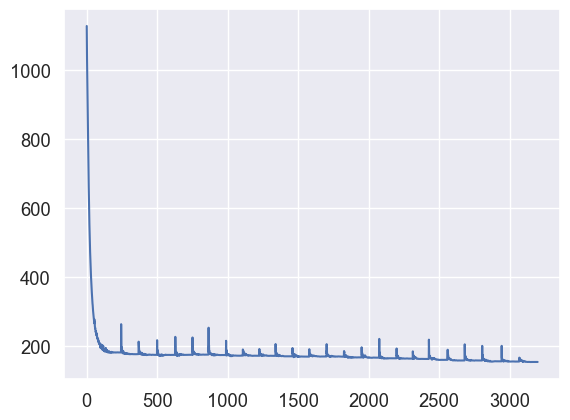

In [21]:
plt.plot(return_dict['eval_losses'])

In [1]:
# optional: save trained model
import datetime
import os
import pickle

timestamp = '-'.join(str(datetime.datetime.now()).split(' '))

data = {'metadata':{'timestamp': timestamp,
                    'save_path': f'./data/biological/trained_models/'},
        'params':{'seed':seed,
                    'sigma': 0.1,
                    'batch_size': batch_size,
                    'tsteps': 15,
                    'input_dim': input_dim,
                    'd_model': d_model,
                    'num_heads': num_heads,
                    'hidden_dim': hidden_dim,
                    'output_dim': output_dim,
                    'n_layers': n_layers,
                    'num_epochs': num_epochs,
                    'n_cycles': n_cycles},
        'return_dict': return_dict
        }

torch.save(return_dict['best_eval_params'], save_path / f"JAN23-stim-LS-transformer-param-{d_model}-{num_heads}-{hidden_dim}-{n_layers}-trained-{n_cycles}.pth", 'rb')
with open(save_path / f'JAN23-stim-LS-transformer-param-metadata-{d_model}-{num_heads}-{hidden_dim}-{n_layers}-trained-{n_cycles}.pkl', 'wb') as f:
    pickle.dump(data, f)
print(f'Saved model parameters and training stats to ./save/trained_models/JAN23/JAN23-stim-LS-transformer-param-metadata-{d_model}-{num_heads}-{hidden_dim}-{n_layers}-trained-{n_cycles}')

NameError: name 'seed' is not defined

Load best model parameters and show test losses

In [23]:
with open(save_path / f'JAN23-stim-LS-transformer-param-metadata-{d_model}-{num_heads}-{hidden_dim}-{n_layers}-trained-{n_cycles}.pkl', 'rb') as f:
    data = pickle.load(f)
best_eval_params = torch.load(save_path /f'JAN23-stim-LS-transformer-param-{d_model}-{num_heads}-{hidden_dim}-{n_layers}-trained-{n_cycles}.pth')
DNN_LS.load_state_dict(best_eval_params)

with torch.no_grad():
    Y_hat_LS = DNN_LS(X_test.to(device).permute(1,0,2)).permute(1,0,2).cpu()
    LS_test_pred_loss = nn.MSELoss(reduction='none')(Y_hat_LS, Y_test[...,LS_neuron_idx])
    print('Overall Transformer Loss:', LS_test_pred_loss.sum()/np.prod(LS_test_pred_loss.shape))
    print('Transformer prediction for forward stim MSE loss: ', LS_test_pred_loss[forward_mse_idx].sum()/len(forward_mse_idx)/output_dim)
    print('Transformer prediction for backward stim MSE loss: ', LS_test_pred_loss[backward_mse_idx].sum() / len(backward_mse_idx)/output_dim)
    print('Transformer prediction for random stim MSE loss: ', LS_test_pred_loss[random_mse_idx].sum() / len(random_mse_idx)/output_dim)
    print('Transformer prediction for non-stim stim MSE loss: ', LS_test_pred_loss[non_stim_mse_idx].sum() / len(non_stim_mse_idx)/output_dim)

Overall Transformer Loss: tensor(155.0493)
Transformer prediction for forward stim MSE loss:  tensor(151.9235)
Transformer prediction for backward stim MSE loss:  tensor(157.0850)
Transformer prediction for random stim MSE loss:  tensor(182.6735)
Transformer prediction for non-stim stim MSE loss:  tensor(142.3716)


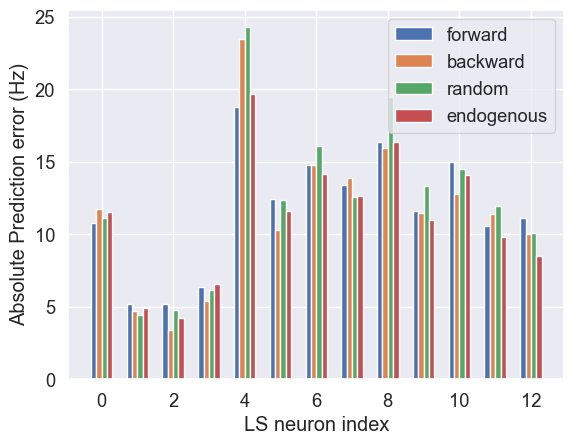

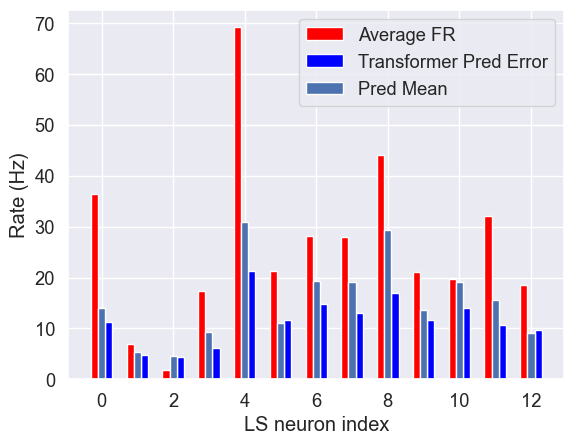

In [24]:
plt.figure()
plt.bar(np.arange(len(LS_neuron_idx)) - 0.225, torch.sqrt(LS_test_pred_loss[forward_mse_idx, 0].sum(0)/len(forward_mse_idx)), width=0.15, label='forward')
plt.bar(np.arange(len(LS_neuron_idx)) - 0.075, torch.sqrt(LS_test_pred_loss[backward_mse_idx, 0].sum(0)/len(backward_mse_idx)), width=0.15, label='backward')
plt.bar(np.arange(len(LS_neuron_idx)) + 0.075, torch.sqrt(LS_test_pred_loss[random_mse_idx, 0].sum(0)/len(random_mse_idx)), width=0.15, label='random')
plt.bar(np.arange(len(LS_neuron_idx)) + 0.225, torch.sqrt(LS_test_pred_loss[non_stim_mse_idx, 0].sum(0)/len(non_stim_mse_idx)), width=0.15, label='endogenous')

plt.xlabel('LS neuron index')
plt.ylabel('Absolute Prediction error (Hz)')
plt.legend()
plt.show()

plt.figure()
plt.bar(np.arange(len(LS_neuron_idx)) - 0.2, spks_stim_rates.mean(0)[LS_neuron_idx], color='red', width=0.2, label='Average FR')
plt.bar(np.arange(len(LS_neuron_idx)) + 0.2, torch.sqrt(LS_test_pred_loss.sum(0)[0]/LS_test_pred_loss.shape[0]), color='blue', width=0.2, label='Transformer Pred Error')
try:
    Y_test_LS_np
    plt.bar(np.arange(len(LS_neuron_idx)), np.sqrt(np.power(Y_test_LS_np - Y_test_LS_np.mean(0), 2).sum(0) / Y_test_LS_np.shape[0]), width=0.2, label='Pred Mean')
except: pass

plt.xlabel('LS neuron index')
plt.ylabel('Rate (Hz)')
plt.legend()
plt.show()

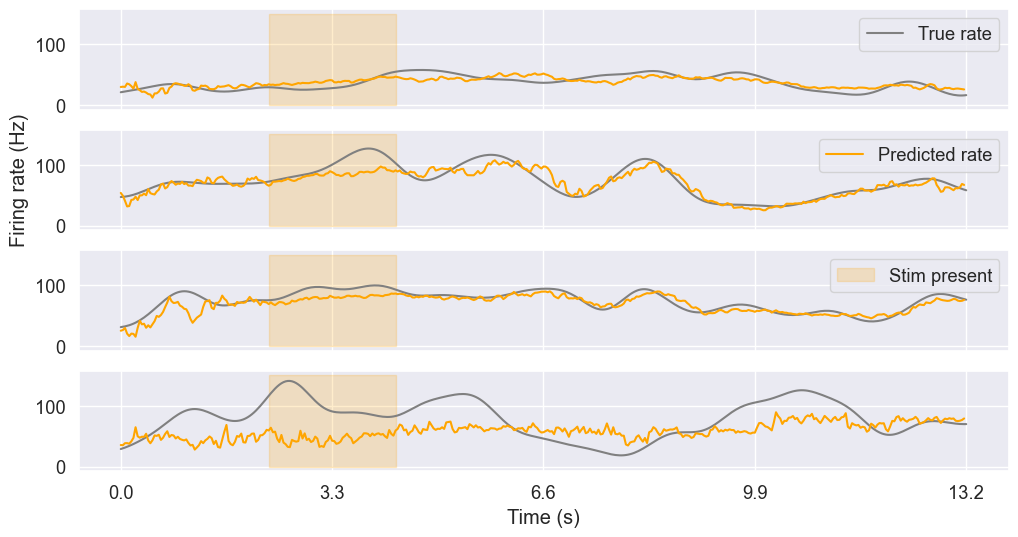

In [27]:
f, axes = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(12,6))

axes[0].plot(ephys_rates[50000:50401,0], c='gray', label='True rate')
axes[0].plot(example_y_LS[:,:, 0].cpu(), c='orange')
axes[0].fill_betweenx([0,150], x1=70, x2=130, color='orange', alpha=0.2)
axes[0].legend(loc='upper right')

axes[1].plot(ephys_rates[50000:50401,4], c='gray')
axes[1].plot(example_y_LS[:,:, 4].cpu(), c='orange', label='Predicted rate')
axes[1].fill_betweenx([0,150], x1=70, x2=130, color='orange', alpha=0.2)
axes[1].set_ylabel('Firing rate (Hz)')
axes[1].legend(loc='upper right')

axes[2].plot(ephys_rates[50000:50401,8], c='gray')
axes[2].plot(example_y_LS[:,:, 8].cpu(), c='orange')
axes[2].fill_betweenx([0,150], x1=70, x2=130, color='orange', alpha=0.2, label='Stim present')
axes[2].legend(loc='upper right')

axes[3].plot(ephys_rates[50000:50401,70], c='gray')
axes[3].plot(example_y_nLS[:,:, 57].cpu(), c='orange')
axes[3].set_xticks(np.arange(0,401,100), [i*33/1000 for i in range(0, 401, 100)])
axes[3].fill_betweenx([0,150], x1=70, x2=130, color='orange', alpha=0.2)

axes[3].set_xlabel('Time (s)')

plt.savefig('./figures/prediction_examples', dpi=350, bbox_inches='tight')
plt.show()

As a comparison, train GLM on each output neuron and show test losses

In [22]:
# pred for each neuron
glm_LS_losses = np.zeros_like(Y_test_LS_np) # (500, 8)
output_dim = Y_test_LS_np.shape[1]

for i in range(output_dim):
    glm_LS_reg = TweedieRegressor(power=0, alpha=1, link='auto')
    glm_LS_reg.fit(X_train_np, Y_train_LS_np[:,i])
    
    glm_LS_losses[:,i] += np.power(Y_test_LS_np[:,i] - glm_LS_reg.predict(X_test_np), 2)
    logger.info(f'Loss for LS neuron No {i}: {glm_LS_losses[:,i].sum() / Y_test_LS_np.shape[0]} (Hz^2).')
    logger.info(f'Forward: {glm_LS_losses[forward_mse_idx,i].sum() / len(forward_mse_idx)}, Backward: {glm_LS_losses[backward_mse_idx,i].sum() / len(backward_mse_idx)}, Random: {glm_LS_losses[random_mse_idx, i].sum() / len(random_mse_idx)}. Endogenous: {glm_LS_losses[non_stim_mse_idx, i].sum() / len(non_stim_mse_idx)}')

logger.info(f'Pred mean overall loss: {np.power(Y_test_LS_np - Y_test_LS_np.mean(0), 2).sum() / np.prod(Y_test_LS_np.shape)}')
logger.info(f'GLM with identity function overall loss: {glm_LS_losses.sum() / np.prod(Y_test_LS.shape)}')

logger.info(f'GLM prediction for forward stim R2 loss: {glm_LS_losses[forward_mse_idx].sum()/len(forward_mse_idx)/output_dim}')
logger.info(f'GLM prediction for backward stim R2 loss: {glm_LS_losses[backward_mse_idx].sum() / len(backward_mse_idx)/output_dim}')
logger.info(f'GLM prediction for random stim R2 loss: {glm_LS_losses[random_mse_idx].sum() / len(random_mse_idx)/output_dim}')
logger.info(f'GLM prediction for non-stim stim R2 loss: {glm_LS_losses[non_stim_mse_idx].sum() / len(non_stim_mse_idx)/output_dim}')

np.save(save_path / 'JAN23-stim-LS-glm-losses.npy', glm_LS_losses)

2024-03-08 15:31:19.278 | INFO     | __main__:<module>:10 - Loss for LS neuron No 0: 158.14346875 (Hz^2).
2024-03-08 15:31:19.279 | INFO     | __main__:<module>:11 - Forward: 143.93904543385923, Backward: 152.666856822401, Random: 180.97945149739584. Endogenous: 157.26314453125
2024-03-08 15:31:24.217 | INFO     | __main__:<module>:10 - Loss for LS neuron No 1: 25.0596015625 (Hz^2).
2024-03-08 15:31:24.217 | INFO     | __main__:<module>:11 - Forward: 23.29439092839806, Backward: 26.778852103960396, Random: 26.897544860839844. Endogenous: 24.2182470703125
2024-03-08 15:31:29.562 | INFO     | __main__:<module>:10 - Loss for LS neuron No 2: 21.7137265625 (Hz^2).
2024-03-08 15:31:29.562 | INFO     | __main__:<module>:11 - Forward: 24.177587416565533, Backward: 26.14624265160891, Random: 18.854729970296223. Endogenous: 19.578736572265626
2024-03-08 15:31:34.890 | INFO     | __main__:<module>:10 - Loss for LS neuron No 3: 66.3679296875 (Hz^2).
2024-03-08 15:31:34.891 | INFO     | __main__:<m

2024-03-11 14:14:23.025 | INFO     | __main__:<module>:2 - Predicting mean for each of the 8 LS neurons: [198.8162    29.729816  21.4272    87.34919  958.23004  120.83153
 377.06995  363.3188   862.4969   183.14201  368.03598  240.77968
  82.26837 ]


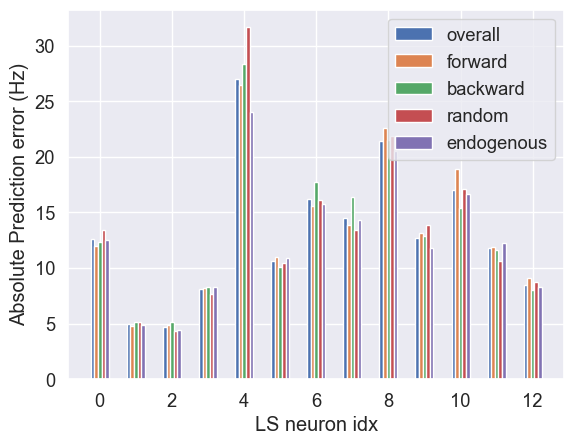

In [25]:
glm_LS_losses = np.load(save_path / 'JAN23-stim-LS-glm-losses.npy')
logger.info(f'Predicting mean for each of the 8 LS neurons: {np.power(Y_test_LS_np - Y_test_LS_np.mean(0), 2).sum(0) / Y_test_LS_np.shape[0]}')

plt.figure()
plt.bar(np.arange(len(LS_neuron_idx))-0.2, np.sqrt(glm_LS_losses.mean(0)), width=0.1, label='overall')
plt.bar(np.arange(len(LS_neuron_idx))-0.1, np.sqrt(glm_LS_losses[forward_mse_idx].mean(0)), width=0.1, label='forward')
plt.bar(np.arange(len(LS_neuron_idx)), np.sqrt(glm_LS_losses[backward_mse_idx].mean(0)), width=0.1, label='backward')
plt.bar(np.arange(len(LS_neuron_idx))+0.1, np.sqrt(glm_LS_losses[random_mse_idx].mean(0)), width=0.1, label='random')
plt.bar(np.arange(len(LS_neuron_idx))+0.2, np.sqrt(glm_LS_losses[non_stim_mse_idx].mean(0)), width=0.1, label='endogenous')
plt.xlabel('LS neuron idx')
plt.ylabel('Absolute Prediction error (Hz)')
plt.legend()
plt.show()

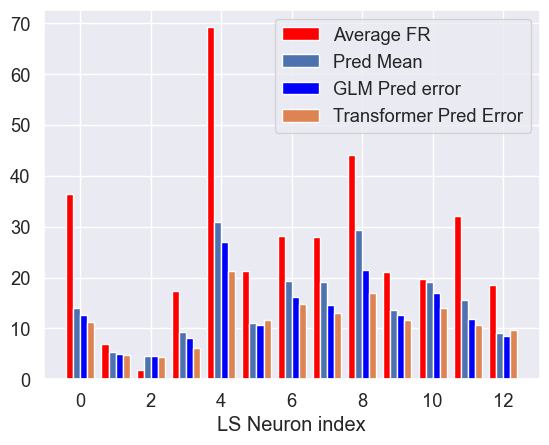

In [26]:
plt.figure()
plt.bar(np.arange(len(LS_neuron_idx)) - 0.3, spks_stim_rates.mean(0)[LS_neuron_idx], color='red', width=0.2, label='Average FR')
plt.bar(np.arange(len(LS_neuron_idx)) - 0.1, np.sqrt(np.power(Y_test_LS_np - Y_test_LS_np.mean(0), 2).sum(0) / Y_test_LS_np.shape[0]), width=0.2, label='Pred Mean')
plt.bar(np.arange(len(LS_neuron_idx)) + 0.1, np.sqrt(glm_LS_losses.sum(0)/glm_LS_losses.shape[0]), color='blue', width=0.2, label='GLM Pred error')
plt.bar(np.arange(len(LS_neuron_idx)) + 0.3, torch.sqrt(LS_test_pred_loss.sum(0)[0]/LS_test_pred_loss.shape[0]), width=0.2, label='Transformer Pred Error')
plt.legend()
plt.xlabel('LS Neuron index')
plt.show()

Loss as a function of data used

In [10]:
import random
a = random.sample([i for i in range(100)], 60)
len(a) == len(np.unique(a))
random.seed(seed)

In [12]:
Y_train_LS = Y_train[..., 0:13]
Y_test_LS = Y_test[..., 0:13]
output_dim = Y_train_LS.shape[-1]

n_repeats = 10
batch_size = 4096
n_vecs = Y_train_LS.shape[0]
print(n_vecs)

proportion_of_data = [0.05 * i for i in range(1,21)]
proportion_of_data_mean_losses = []
proportion_of_data_std_losses = []

from train import train_transformer
from sklearn.linear_model import TweedieRegressor

for i, proportion in enumerate(proportion_of_data):
    means = []
    for _ in range(n_repeats):
        
        rnd_idx = random.sample([i for i in range(n_vecs)], int(proportion * n_vecs))
        train_dataset = BNN_Dataset(X_train[rnd_idx, ...], Y_train_LS[rnd_idx, ...])
        train_dataloader = DataLoader(train_dataset, batch_size=batch_size, drop_last=False, shuffle=True)
        test_dataset = BNN_Dataset(X_test, Y_test_LS)
        test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), drop_last=False, shuffle=False)
        
        _DNN_LS = TransformerDNN(input_dim=input_dim,
                        d_model=220,
                        num_heads=20,
                        hidden_dim=848,
                        output_dim=output_dim,
                        n_layers=5,
                        device=device,
                        pos_output=True,
                        use_mask=False,
                        dropout=0.1,
                        bin_output=False,
                        softmax_output=False).to(device)
        
        optimiser = torch.optim.Adam(_DNN_LS.parameters(), lr=1e-3)
        criterion = nn.MSELoss(reduction='none')
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, 
                                                            mode='min', 
                                                            factor=0.5, 
                                                            patience=25, 
                                                            threshold=0.01)
        num_epochs = 500

        _return_dict = train_transformer(
                    model=_DNN_LS,
                    train_loader=train_dataloader,
                    test_loader=test_dataloader,
                    optimiser=optimiser,
                    criterion=criterion,
                    num_epochs=num_epochs,
                    verbose=False,
                    force_stop=False,
                    scheduler=scheduler,
                    use_wandb=False,
                    stim_type_indices=
                    [forward_mse_idx, backward_mse_idx, random_mse_idx, non_stim_mse_idx])
        
        _DNN_LS.load_state_dict(_return_dict['best_eval_params'])

        with torch.no_grad():
            _Y_hat_LS = _DNN_LS(X_test.to(device).permute(1,0,2)).permute(1,0,2).cpu()
            _LS_test_pred_loss = nn.MSELoss(reduction='none')(_Y_hat_LS, Y_test[...,:13])
        
        
        # fit GLM with identity link function
        X_train_np = X_train[rnd_idx, ...].cpu().numpy().reshape(len(rnd_idx),-1)
        Y_train_LS_np = Y_train_LS[rnd_idx, ...].cpu().numpy().reshape(Y_train_LS[rnd_idx, ...].shape[0],-1) + 1e-6 # numerical stability

        X_test_np = X_test.cpu().numpy().reshape(X_test.shape[0],-1)
        Y_test_LS_np = Y_test_LS.cpu().numpy().reshape(Y_test_LS.shape[0],-1) + 1e-6 # numerical stability


        # pred for each neuron
        _glm_LS_losses = np.zeros(Y_test_LS_np.shape[0])

        for i in tqdm(range(output_dim)):
            _glm_LS_reg = TweedieRegressor(power=0, alpha=1, link='identity')
            _glm_LS_reg.fit(X_train_np, Y_train_LS_np[:,i])
            
            _glm_LS_losses += np.power(Y_test_LS_np[:,i] - _glm_LS_reg.predict(X_test_np), 2)
            
        means.append([_LS_test_pred_loss[forward_mse_idx].sum().numpy()/len(forward_mse_idx)/13,
                                            _LS_test_pred_loss[backward_mse_idx].sum().numpy() / len(backward_mse_idx)/13,
                                            _LS_test_pred_loss[random_mse_idx].sum().numpy() / len(random_mse_idx)/13,
                                            _LS_test_pred_loss[non_stim_mse_idx].sum().numpy() / len(non_stim_mse_idx)/13,
                                            _glm_LS_losses[forward_mse_idx].sum()/len(forward_mse_idx)/13,
                                            _glm_LS_losses[backward_mse_idx].sum() / len(backward_mse_idx)/13,
                                            _glm_LS_losses[random_mse_idx].sum() / len(random_mse_idx)/13,
                                            _glm_LS_losses[non_stim_mse_idx].sum() / len(non_stim_mse_idx)/13])
    proportion_of_data_mean_losses.append(np.mean(np.array(means), axis=0))
    proportion_of_data_std_losses.append(np.std(np.array(means), axis=0))
    

5186


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 13/13 [00:08<00:00,  1.55it/s]
c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 13/13 [00:09<00:00,  1.37it/s]
c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWar

### Train for non-LS neurons only

In [36]:
Y_train_nLS = Y_train[..., 13:]
Y_test_nLS = Y_test[..., 13:]
# Y_valid_nLS = Y_valid[..., 13:]
output_dim = Y_train_nLS.shape[-1]

batch_size = 2048
train_dataset = BNN_Dataset(X_train, Y_train_nLS)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, drop_last=False, shuffle=True)
test_dataset = BNN_Dataset(X_test, Y_test_nLS)
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), drop_last=False, shuffle=False)

# valid_dataset = BNN_Dataset(X_valid, Y_valid_nLS)
# valid_dataloader = DataLoader(valid_dataset, batch_size=len(valid_dataset), drop_last=False, shuffle=False)

Hyperparameter optimisation for transformer using Bayes Opt

In [62]:
from bayes_opt import BayesianOptimization
from models import TransformerOneStep as TransformerDNN
from train import train_transformer, eval_transformer

def black_box_function(d_model, num_heads, hidden_dim, n_layers, seed=seed):
    torch.cuda.empty_cache()
    
    seed = 123
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    hidden_dim, d_model, n_layers, num_heads = int(hidden_dim), int(d_model), int(n_layers), int(num_heads)
    d_model = int(int(d_model/num_heads)*num_heads) # d_model must be multiples of n_heads
    if d_model %2 != 0:
        d_model += num_heads
        
    DNN = TransformerDNN(input_dim=input_dim,
                        d_model=d_model,
                        num_heads=num_heads,
                        hidden_dim=hidden_dim,
                        output_dim=output_dim,
                        n_layers=n_layers,
                        device=device,
                        pos_output=True,
                        use_mask=True,
                        dropout=0.1,
                        bin_output=False,
                        softmax_output=False).to(device)
    
    optimiser = torch.optim.Adam(DNN.parameters(), lr=1e-3)
    criterion = nn.MSELoss()
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimiser, gamma=0.99)

    return_dict = train_transformer(
        model=DNN,
        train_loader=train_dataloader, test_loader=test_dataloader, # use valid loader here
        optimiser=optimiser, criterion=criterion, num_epochs=500,
        verbose=False, force_stop=False, scheduler=scheduler)

    return -min(return_dict['eval_losses'])

def run_bayes_opt(pbounds, init_points=100, n_iter=100):
    optimizer = BayesianOptimization(f=black_box_function, pbounds=pbounds, random_state=1)
    optimizer.maximize(init_points=init_points, n_iter=n_iter)

run_bayes_opt(pbounds = {'d_model':(100, 1000),
               'num_heads':(1, 20),
               'hidden_dim':(100, 1000),
               'n_layers':(1, 5)}, init_points=50, n_iter=50)

|   iter    |  target   |  d_model  | hidden... | n_layers  | num_heads |
-------------------------------------------------------------------------


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
  3%|▎         | 16/500 [00:06<03:05,  2.61it/s]


KeyboardInterrupt: 

Train transformer

In [12]:
# TRANSFORMER
# | 67        | -240.9    | 992.8     | 923.3     | 2.437     | 19.03     |
# | 6         | -242.3    | 820.7     | 971.4     | 2.254     | 14.15     |
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from models import TransformerOneStep as TransformerDNN
DNN_nLS = TransformerDNN(input_dim=input_dim,
                    d_model=988,
                    num_heads=19,
                    hidden_dim=923,
                    output_dim=output_dim,
                    n_layers=2,
                    device=device,
                    pos_output=True,
                    use_mask=False,
                    dropout=0.1,
                    bin_output=False,
                    softmax_output=False).to(device)

assert len(stim_id) == len(stim_vecs_idx)
forward_mse_idx = list(np.nonzero(np.array(stim_id) == 'a')[0])
backward_mse_idx = list(np.nonzero(np.array(stim_id) == 'b')[0])
random_mse_idx = list(np.nonzero(np.array(stim_id) == 'c')[0])
non_stim_mse_idx = np.arange(len(stim_id), Y_test.shape[0])

assert len(np.intersect1d(forward_mse_idx, backward_mse_idx)) == 0
assert len(np.intersect1d(backward_mse_idx, random_mse_idx)) == 0
assert len(np.intersect1d(random_mse_idx, non_stim_mse_idx)) == 0
assert len(np.intersect1d(non_stim_mse_idx, forward_mse_idx)) == 0


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [13]:

import wandb
wandb.login()
wandb.init(project='approx_brain')

optimiser = torch.optim.Adam(DNN_nLS.parameters(), lr=1e-3)
criterion = nn.MSELoss(reduction='none')
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, 
                                                       mode='min', 
                                                       factor=0.5, 
                                                       patience=25, 
                                                       threshold=0.01)
num_epochs = 500

from train import train_transformer, eval_transformer

return_dict = train_transformer(
            model=DNN_nLS,
            train_loader=train_dataloader,
            test_loader=test_dataloader,
            optimiser=optimiser,
            criterion=criterion,
            num_epochs=num_epochs,
            verbose=False,
            force_stop=False,
            scheduler=scheduler,
            use_wandb=True,
            stim_type_indices=[forward_mse_idx, backward_mse_idx, random_mse_idx, non_stim_mse_idx])

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


backward_loss,█▇▆▅▄▄▃▃▃▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_loss,█▇▆▅▄▄▃▃▃▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
forward_loss,█▇▆▅▄▄▄▃▃▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
learning_rate,█████████████████████████▄▄▃▃▂▂▁▁▁▁▁▁▁▁▁
nonstim_loss,█▇▅▅▄▄▃▃▃▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
random_loss,█▇▆▅▄▄▃▃▃▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▇▆▅▅▄▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
backward_loss,161.80854
eval_loss,166.04222
forward_loss,133.02736
learning_rate,0.0


100%|██████████| 500/500 [09:26<00:00,  1.13s/it]


In [ ]:
# optional: save trained model
import datetime
import os
import pickle

timestamp = '-'.join(str(datetime.datetime.now()).split(' '))

data = {'metadata':{'timestamp': timestamp,
                    'save_path': f'./data/biological/trained_models/'},
        'params':{'seed':seed,
                    'sigma': 0.1,
                    'batch_size': batch_size,
                    'tsteps': tsteps,
                    'input_dim': input_dim,
                    'd_model': 988,
                    'num_heads': 19,
                    'hidden_dim': 848,
                    'output_dim': output_dim,
                    'n_layers': 2,
                    'num_epochs': num_epochs},
        'train_data': return_dict}

with open(f'./data/biological/trained_models/nLS-transformer-param.pkl', 'wb') as f:
    pickle.dump(data, f)
print(f'Saved model parameters and training stats to ./data/biological/trained_models/nLS-transformer-param.pkl')

Load best model parameters and show test losses

In [14]:
with open('./data/biological/trained_models/nLS-transformer-param.pkl', 'rb') as f:
    data = pickle.load(f)
    f.close()
return_dict = data['train_data']
    
DNN_nLS.load_state_dict(return_dict['best_eval_params'])

with torch.no_grad():
    Y_hat_nLS = DNN_nLS(X_test.to(device).permute(1,0,2)).permute(1,0,2).cpu()
    nLS_test_pred_loss = nn.MSELoss(reduction='none')(Y_hat_nLS, Y_test[...,13:])
    print('Transformer prediction for forward stim MSE loss: ', nLS_test_pred_loss[forward_mse_idx].sum()/len(forward_mse_idx)/output_dim)
    print('Transformer prediction for backward stim MSE loss: ', nLS_test_pred_loss[backward_mse_idx].sum() / len(backward_mse_idx)/output_dim)
    print('Transformer prediction for random stim MSE loss: ', nLS_test_pred_loss[random_mse_idx].sum() / len(random_mse_idx)/output_dim)
    print('Transformer prediction for non-stim stim MSE loss: ', nLS_test_pred_loss[non_stim_mse_idx].sum() / len(non_stim_mse_idx)/output_dim)

Transformer prediction for forward stim MSE loss:  tensor(257.8112)
Transformer prediction for backward stim MSE loss:  tensor(237.3791)
Transformer prediction for random stim MSE loss:  tensor(253.9427)
Transformer prediction for non-stim stim MSE loss:  tensor(240.6133)


As a comparison, train GLM on each output neuron and show test losses

In [37]:
# fit GLM with identity link function
X_train_np = X_train.cpu().numpy().reshape(X_train.shape[0],-1)
Y_train_nLS_np = Y_train_nLS.cpu().numpy().reshape(Y_train_nLS.shape[0],-1) + 1e-6 # numerical stability

X_test_np = X_test.cpu().numpy().reshape(X_test.shape[0],-1)
Y_test_nLS_np = Y_test_nLS.cpu().numpy().reshape(Y_test_nLS.shape[0],-1) + 1e-6 # numerical stability

output_dim = Y_test_nLS.shape[-1]
print(output_dim)

from sklearn.linear_model import TweedieRegressor

# pred for each neuron
glm_nLS_losses = np.zeros(Y_test_nLS_np.shape[0])
output_dim = Y_test_nLS_np.shape[1]

for i in tqdm(range(output_dim)):
    glm_nLS_reg = TweedieRegressor(power=0, alpha=1, link='identity')
    glm_nLS_reg.fit(X_train_np, Y_train_nLS_np[:,i])
    
    glm_nLS_losses += np.power(Y_test_nLS_np[:,i] - glm_nLS_reg.predict(X_test_np), 2)
    
glm_loss = glm_nLS_losses.sum() / Y_test_nLS.shape[0] / output_dim
print('GLM with identity function loss: ', glm_loss)

print('GLM prediction for forward stim R2 loss: ', glm_nLS_losses[forward_mse_idx].sum()/len(forward_mse_idx)/output_dim)
print('GLM prediction for backward stim R2 loss: ', glm_nLS_losses[backward_mse_idx].sum() / len(backward_mse_idx)/output_dim)
print('GLM prediction for random stim R2 loss: ', glm_nLS_losses[random_mse_idx].sum() / len(random_mse_idx)/output_dim)
print('GLM prediction for non-stim stim R2 loss: ', glm_nLS_losses[non_stim_mse_idx].sum() / len(non_stim_mse_idx)/output_dim)

64


100%|██████████| 64/64 [20:34<00:00, 19.28s/it]

GLM with identity function loss:  244.36139256351652
GLM prediction for forward stim R2 loss:  255.92479352666675
GLM prediction for backward stim R2 loss:  233.47904503814704
GLM prediction for random stim R2 loss:  241.03628430390538
GLM prediction for non-stim stim R2 loss:  245.49787853241898


### Second dataset

In [12]:
area_idx = np.load('./data/biological/Aug23/area_idx.npy') # 92 neurons, idx 0-76 'LS', 77-91 'ACC'
ephys_array = np.load('./data/biological/Aug23/ephys_array.npy') # (92, 536020) at 1 ms
ephys_stim_a = np.load('./data/biological/Aug23/ephys_stim_a.npy') # type A stim timings, 50 in total
ephys_stim_b = np.load('./data/biological/Aug23/ephys_stim_b.npy') # type B stim timings, 50 in total
img_array = np.load('./data/biological/Aug23/img_array.npy') # (189, 19010)
img_stim_a = np.load('./data/biological/Aug23/img_stim_a.npy')
img_stim_b = np.load('./data/biological/Aug23/img_stim_b.npy')

In [14]:
# align timings
# img_array starts and then ephys.
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(img_stim_a.reshape(-1, 1), ephys_stim_a.reshape(-1, 1))
print(f'Linearity correlation: {reg.score(img_stim_a.reshape(-1, 1), ephys_stim_a.reshape(-1, 1))}')
offset = int(reg.intercept_.squeeze())
freq = reg.coef_.squeeze()
print(f'Offset between GCaMP and Neuropixel is {offset} ms.')
print(f'Sampling frequency for GCaMP is {freq} Hz.')

# the ephys starts first and imaging a bit later
ephys_array = ephys_array[:, offset:]
ephys_stim_a = np.array([a - offset for a in ephys_stim_a])
ephys_stim_b = np.array([b - offset for b in ephys_stim_b])
print(f'Total EPhys recording time: {ephys_array.shape[1]/1000} s')

Linearity correlation: 0.9999999965150472
Offset between GCaMP and Neuropixel is 7478 ms.
Sampling frequency for GCaMP is 33.29890144832494 Hz.
Total EPhys recording time: 528.542 s


In [37]:
img_array = img_array[:, :int(ephys_array.shape[1]/freq)]
img_array.shape

(189, 15872)

In [39]:
np.max(img_stim_a)

17157

In [38]:
# downsample ephys to 33 hertz
ephys_array_ds = np.zeros(ephys_array.shape[0]. img_array.shape[1])
for bin in range(img_array.shape[1]):
    ephys_array_ds[]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

# Poster graphs

### Example of GCaMP data

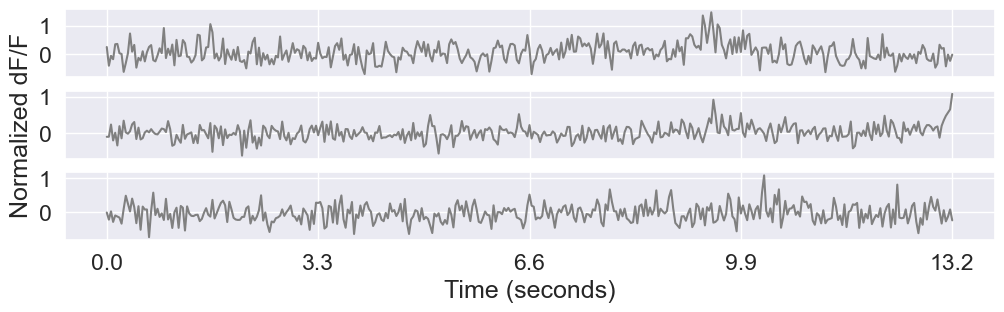

In [94]:
sns.set(font_scale=1.5)
f, axes = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(12,3))

axes[0].plot(img_array[50000:50401,7], c='gray')

axes[1].plot(img_array[50000:50401,126], c='gray')
axes[1].set_ylabel('Normalized dF/F')


axes[2].plot(img_array[50000:50401,268], c='gray')
axes[2].set_xticks(np.arange(0,401,100), [i*33/1000 for i in range(0, 401, 100)])

plt.xlabel('Time (seconds)')
plt.savefig('./figures/sample_fluorescence', dpi=350, bbox_inches='tight')

plt.show()

### Example of EPhys data

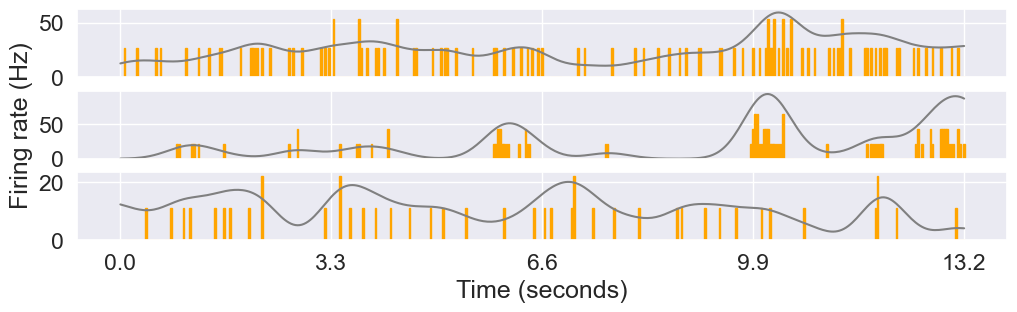

In [67]:
f, axes = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(12,3))

axes[0].plot(ephys_rates[50000:50401,15], c='gray')
axes[0].bar(np.arange(401), height = ephys_array[15, 50000:50401] * ephys_rates[50000:50401,15].mean().numpy(), color='orange', edgecolor='orange', label='spikes')

axes[1].plot(ephys_rates[50000:50401,67], c='gray')
axes[1].bar(np.arange(401), height = ephys_array[67, 50000:50401] * ephys_rates[50000:50401,67].mean().numpy(), color='orange', edgecolor='orange', label='spikes')
axes[1].set_ylabel('Firing rate (Hz)')

axes[2].plot(ephys_rates[50000:50401,3], c='gray')
axes[2].bar(np.arange(401), height = ephys_array[3, 50000:50401] * ephys_rates[50000:50401,3].mean().numpy(), color='orange', edgecolor='orange', label='spikes')
axes[2].set_xticks(np.arange(0,401,100), [i*33/1000 for i in range(0, 401, 100)])

plt.xlabel('Time (seconds)')
plt.savefig('./figures/sample_rates', dpi=350, bbox_inches='tight')

plt.show()

### Comparison of losses

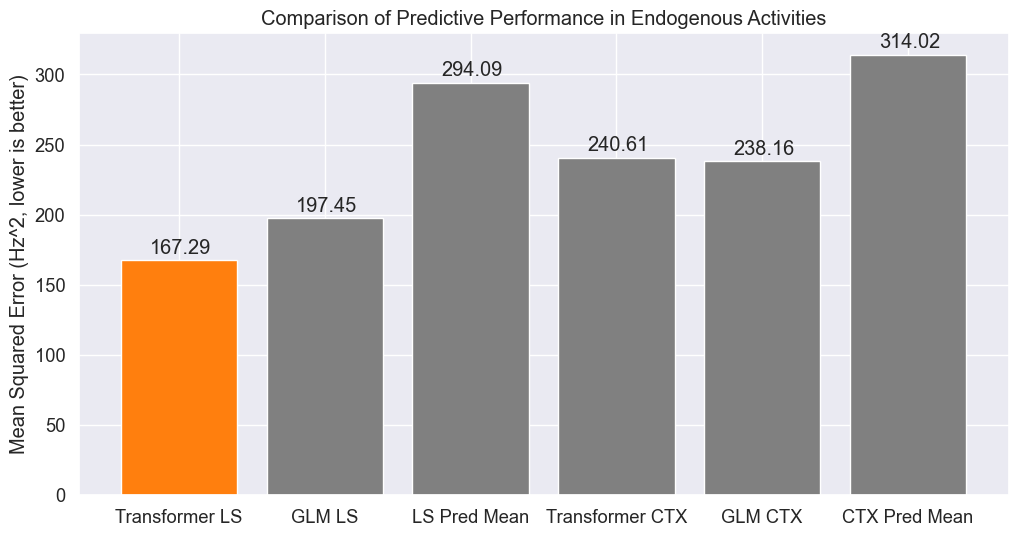

In [22]:
#pred_mean_loss = nn.MSELoss(reduction='none')(Y_test, torch.mean(Y_train, dim=(0,1)))

#endogenous_losses = np.array([
#    LS_test_pred_loss[non_stim_mse_idx].sum()/len(non_stim_mse_idx)/13,
#    glm_LS_losses[non_stim_mse_idx].sum() / len(non_stim_mse_idx)/13,
#    pred_mean_loss[non_stim_mse_idx, :, :13].sum() / len(non_stim_mse_idx)/13,
#    nLS_test_pred_loss[non_stim_mse_idx].sum() / len(non_stim_mse_idx)/64,
#    glm_nLS_losses[non_stim_mse_idx].sum() / len(non_stim_mse_idx)/64,
#        pred_mean_loss[non_stim_mse_idx, :, :64].sum() / len(non_stim_mse_idx)/64
#])

 # 167.29, 197.45, 294.09, 240.61, 238.16, 314.02
endogenous_losses = [167.29, 197.45, 294.09, 240.61, 238.16, 314.02]
sns.set(font_scale=1.2)
plt.figure(figsize=(12,6))
bars = plt.bar(np.arange(6), endogenous_losses, color=[u'#ff7f0e', u'#808080', u'#808080', u'#808080', u'#808080', u'#808080'])
for i, rect in enumerate(bars):
    height = rect.get_height()
    plt.text(rect.get_x()+  rect.get_width() / 4, height + 5, str(endogenous_losses[i])[:6])
plt.xticks(np.arange(6), ['Transformer LS', 'GLM LS', 'LS Pred Mean', 'Transformer CTX', 'GLM CTX', 'CTX Pred Mean'])
plt.ylabel('Mean Squared Error (Hz^2, lower is better)')
plt.title('Comparison of Predictive Performance in Endogenous Activities')
plt.savefig('./figures/endogenous_activities_comparison.png', dpi=350, bbox_inches='tight')
plt.show()

In [39]:
pred_mean_loss = nn.MSELoss(reduction='none')(Y_test, torch.mean(Y_train, dim=(0,1)))
pred_mean_loss.shape

c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([77])) that is different to the input size (torch.Size([500, 1, 77])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([500, 1, 77])

#### Bar plots

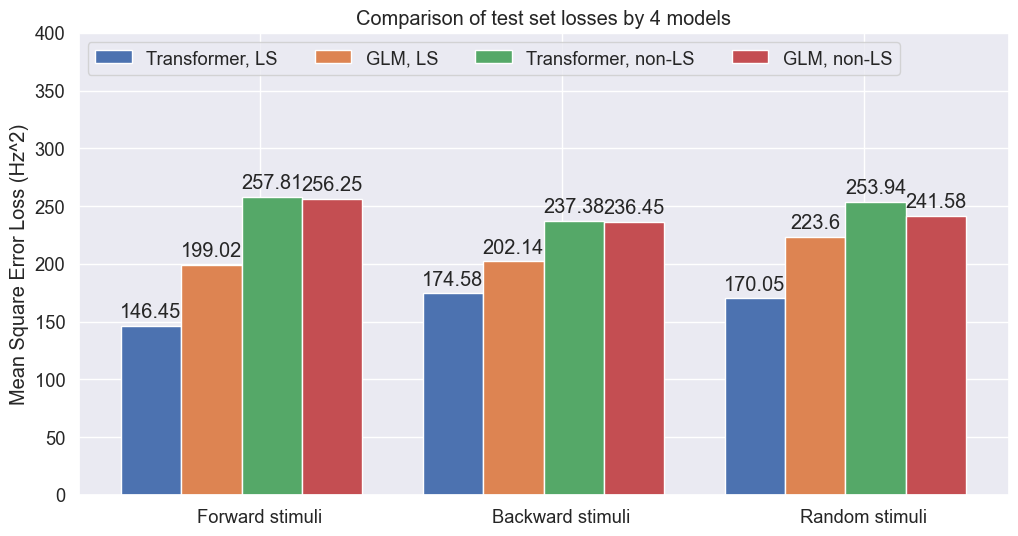

In [42]:
sns.set(font_scale=1.2)
stim_types = ['Forward stimuli', 'Backward stimuli', 'Random stimuli']
mses = {
    'Transformer, LS': (146.45, 174.58, 170.05),
    'GLM, LS': (199.02, 202.14, 223.60),
    'Transformer, non-LS': (257.81, 237.38, 253.94),
    'GLM, non-LS': (256.25,236.45,241.58)
}

x = np.arange(len(stim_types))
width = 0.2  # the width of the bars
multiplier = -0.8
fig, ax = plt.subplots(figsize=(12,6))

for model, loss in mses.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, loss, width, label=model)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Mean Square Error Loss (Hz^2)')
ax.set_title('Comparison of test set losses by 4 models')
ax.set_xticks(x + width, stim_types)
ax.legend(loc='upper left', ncols=4)
ax.set_ylim(0, 400)

plt.savefig('./figures/loss_bar_plot', bbox_inches='tight', dpi=350)
plt.show()


#### Violin plots

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,12))
colors = ['r', 'b', 'b', 'b']

nstim_losses = [LS_test_pred_loss[non_stim_mse_idx].sum((1,2))/13, glm_LS_losses[non_stim_mse_idx]/13, nLS_test_pred_loss[non_stim_mse_idx].sum((1,2))/64, glm_nLS_losses[non_stim_mse_idx]/64]
vplots = axes[0,0].violinplot(nstim_losses, showextrema=False, showmeans=True, showmedians=True, bw_method=1)
for pc, c in zip(vplots['bodies'], colors):
    pc.set_facecolor(c)
axes[0,0].set_xticks(np.arange(1,5), mses.keys())
axes[0,0].set_title('Endogenous activities', fontsize=12)
axes[0,0].set_ylabel('Mean Square Error Loss (Hz^2)')

forward_losses = [LS_test_pred_loss[forward_mse_idx].sum((1,2))/13, glm_LS_losses[forward_mse_idx]/13, nLS_test_pred_loss[forward_mse_idx].sum((1,2))/64, glm_nLS_losses[forward_mse_idx]/64]
vplots = axes[0,1].violinplot(forward_losses, showextrema=False, showmeans=True, showmedians=True, bw_method=1)
for pc, c in zip(vplots['bodies'], colors):
    pc.set_facecolor(c)
axes[0,1].set_xticks(np.arange(1,5), mses.keys())
axes[0,1].set_title('Forward stimuli', fontsize=12)
axes[0,1].set_ylabel('Mean Square Error Loss (Hz^2)')


backward_losses = [LS_test_pred_loss[backward_mse_idx].sum((1,2))/13, glm_LS_losses[backward_mse_idx]/13, nLS_test_pred_loss[backward_mse_idx].sum((1,2))/64, glm_nLS_losses[backward_mse_idx]/64]
vplots = axes[1,0].violinplot(forward_losses, showextrema=False, showmeans=True, showmedians=True, bw_method=1)
for pc, c in zip(vplots['bodies'], colors):
    pc.set_facecolor(c)
axes[1,0].set_xticks(np.arange(1,5), mses.keys())
axes[1,0].set_title('Backward activities', fontsize=12)
axes[1,0].set_ylabel('Mean Square Error Loss (Hz^2)')


random_losses = [LS_test_pred_loss[random_mse_idx].sum((1,2))/13, glm_LS_losses[random_mse_idx]/13, nLS_test_pred_loss[random_mse_idx].sum((1,2))/64, glm_nLS_losses[random_mse_idx]/64]
vplots = axes[1,1].violinplot(forward_losses, showextrema=False, showmeans=True, showmedians=True, bw_method=1)
for pc, c in zip(vplots['bodies'], colors):
    pc.set_facecolor(c)
axes[1,1].set_xticks(np.arange(1,5), mses.keys())
axes[1,1].set_title('Random activities', fontsize=12)
axes[1,1].set_ylabel('Mean Square Error Loss (Hz^2)')

plt.savefig('./figures/violin_loss_plot', bbox_inches='tight', dpi=350)
plt.show()


### ACF in GCaMP

In [ ]:
def compute_acf(data, lag=0):
    '''
    Data: shape (time_steps, dim)
    '''
    mean_ts = torch.mean(data, axis=0)
    var_ts = torch.var(data, axis=0)
    ts_len = data.shape[0]

    autocorr = np.zeros(data.shape[1])

    for i in range(data.shape[1]):
        if lag == 0:
            autocorr[i] = 1  # Autocorrelation at lag 0 is always 1
        else:
            autocorr[i] = torch.sum((data[:ts_len - lag, i] - mean_ts[i]) *
                                 (data[lag:, i] - mean_ts[i])) / (var_ts[i] * (ts_len - lag))
    return autocorr

img_array_acfs = np.array([compute_acf(img_array, lag=i) for i in range(0,41)]).T
plt.figure(figsize=(12, 8))
sns.heatmap(img_array_acfs, cmap='viridis')
plt.xlabel('Lag')
plt.yticks(np.linspace(0, img_array.shape[1], 10), map(int, np.linspace(0, img_array.shape[1], 10)))
plt.ylabel('HPC Neuron index')
plt.title('Heatmap of HPC All-Optical Autocorrelation')
plt.savefig('./figures/acf_img_array', bbox_inches='tight', dpi=350)
plt.show()

### Attention maps in the Encoder Layers

In [ ]:
'''
NOTE BY DANIEL

In order to extract attention weights we need to tweak the torch source code.
Go to torch.nn.modules.transformer
and set all key worded arguments when forward-passing the MultiHeadAttention module
needs_weight False -> True
then attack the following hook
'''
def get_attention_hook(attention_weights_dict, layer_name):
    def hook(module, input, output):
        if len(output) == 2:
            attention_weights_dict[layer_name] = output[1].detach()
    return hook

attention_weights_dict = {}

for name, module in DNN_LS.named_modules():
    if isinstance(module, 
                  torch.nn.MultiheadAttention):
        hook = get_attention_hook(attention_weights_dict, name)
        module.register_forward_hook(hook)
        
with torch.no_grad():
    Y_test_nLS_hat = DNN_LS(X_test.permute(1,0,2).to(device))

In [ ]:
# plot average attention map for each layer

f, axes = plt.subplots(ncols=5, nrows=1, sharey=True, figsize=(20,5))
for layer, attn_w in enumerate(attention_weights_dict.values()):
    m = axes[layer].matshow(torch.mean(attn_w, dim=0).cpu().numpy(), cmap='Blues')
    f.colorbar(m, shrink=0.7)
    axes[layer].set_xticks(np.arange(0, 15, 5), np.arange(1, 16, 5))
    axes[layer].set_yticks(np.arange(0, 15, 5), np.arange(1, 16, 5))
    axes[layer].set_title(f'Attention map for layer {layer+1}')

plt.savefig('./figures/attn_maps', bbox_inches='tight', dpi=350)
plt.show()

### Optimal Prediction offset steps

In [ ]:
tsteps = 15
assert ephys_rates.shape[0] == img_array.shape[0]

n_vecs = int(ephys_rates.shape[0] / tsteps)
input_dim = img_array.shape[1]
output_dim = ephys_rates.shape[1]
n_vecs = int(ephys_rates.shape[0]/tsteps)
n_stims = len(stim_time)

# pre-process data into train and test sets
inputs, targets = torch.zeros(n_vecs, tsteps, input_dim), torch.zeros(n_vecs, 1, output_dim)
ephys_rates = torch.as_tensor(ephys_rates)
img_array = torch.as_tensor(img_array)

sweeplen = tsteps * 4
glm_loss_sweep = np.zeros((599, output_dim, sweeplen))

for s, loc in tqdm(enumerate(range(-4*tsteps, 4*tsteps, 1))):
    # begin sweep
    for n in range(2, n_vecs-2):
        inputs[n,:,:] = img_array[n*tsteps:(n+1)*tsteps,:]
        targets[n,:,:] = ephys_rates[n*tsteps+loc:n*tsteps+loc+1,:]

    stim_vecs_idx = np.array([int(stim_time[i]/15) for i in range(n_stims)])
    non_stim_vecs_idx = [i for i in range(4, n_vecs-4) if i not in stim_vecs_idx] # exclude padding steps

    # exogenous as test dataset
    X_test, Y_test = inputs[stim_vecs_idx], targets[stim_vecs_idx]
    X, Y = inputs[non_stim_vecs_idx], targets[non_stim_vecs_idx]

    from utils import randomise_dataset_split
    X_train, X_test_non_stim, X_valid, Y_train, Y_test_non_stim, Y_valid = randomise_dataset_split(X, Y, split_ratio=(0.85,0.05,0.1))
    X_test, Y_test = torch.vstack((X_test, X_test_non_stim)), torch.vstack((Y_test, Y_test_non_stim))
    
    # fit GLM
    X_train_np = X_train.cpu().numpy().reshape(X_train.shape[0],-1)
    Y_train_np = Y_train.cpu().numpy().reshape(Y_train.shape[0],-1) + 1e-6 # numerical stability

    X_test_np = X_test.cpu().numpy().reshape(X_test.shape[0],-1)
    Y_test_np = Y_test.cpu().numpy().reshape(Y_test.shape[0],-1) + 1e-6 # numerical stability

    from sklearn.linear_model import TweedieRegressor

    # pred for each neuron
    glm_losses = np.zeros(Y_test_np.shape[0])
    output_dim = Y_test_np.shape[1]

    for i in range(output_dim):
        glm_reg = TweedieRegressor(power=0, alpha=1, link='identity')
        glm_reg.fit(X_train_np, Y_train_np[:,i])
        
        R2_loss = np.power(Y_test_np[:,i] - glm_reg.predict(X_test_np), 2)
        glm_losses += R2_loss
        glm_loss_sweep[:, i, s] = R2_loss
    print(f'GLM with identity link function loss on step {s}: {glm_losses.sum() / Y_test.shape[0] / output_dim}')

In [ ]:
# plot GLM loss wrt offset
plt.plot(glm_loss_sweep.sum(1).sum(0)/599/77)
plt.xticks(np.arange(0, tsteps * 4, 5), np.arange(- 2*tsteps, 2*tsteps, 5))
plt.xlabel('EPhys vs GCaMP Offset')
plt.ylabel('GLM R2 loss')
plt.show()

### Data Efficiency

In [128]:
np.save('./proportion_of_data_mean_losses.npy', proportion_of_data_mean_losses)
np.save('./proportion_of_data_std_losses.npy', proportion_of_data_std_losses)

In [29]:
proportion_of_data_mean_losses = np.load('./proportion_of_data_mean_losses.npy')
proportion_of_data_std_losses = np.load('./proportion_of_data_std_losses.npy')

In [135]:
proportion_of_data_mean_losses.shape
transformer_losses = proportion_of_data_mean_losses[:,0] * 0.2 + proportion_of_data_mean_losses[:,1] * 0.2 + proportion_of_data_mean_losses[:,2] * 0.2 + proportion_of_data_mean_losses[:,3] * 0.4

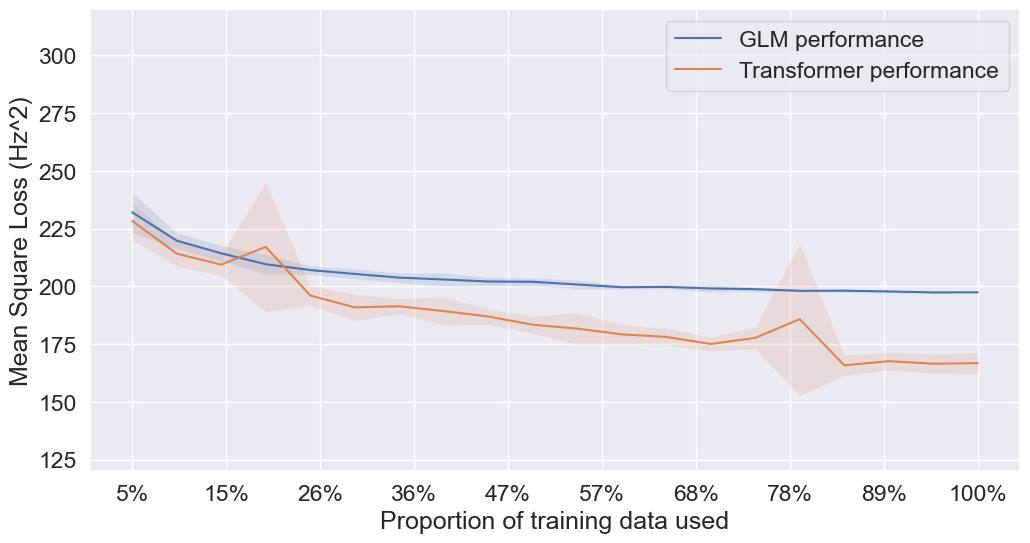

In [34]:
sns.set(font_scale=1.5)
plt.figure(figsize=(12,6))
# plt.plot([np.array(i[0]) for i in proportion_of_data_mean_losses], label='forward stimuli')
# plt.fill_between(np.arange(20), np.array([np.array(i[0]) for i in proportion_of_data_mean_losses]) - [np.array(i[0]) for i in proportion_of_data_std_losses],
#                  np.array([np.array(i[0]) for i in proportion_of_data_mean_losses]) + [np.array(i[0]) for i in proportion_of_data_std_losses], alpha=0.15)
# plt.plot([np.array(i[1]) for i in proportion_of_data_mean_losses], label='backward stimuli')
# plt.fill_between(np.arange(20), np.array([np.array(i[1]) for i in proportion_of_data_mean_losses]) - [np.array(i[1]) for i in proportion_of_data_mean_losses],
#                  np.array([np.array(i[1]) for i in proportion_of_data_mean_losses]) + [np.array(i[1]) for i in proportion_of_data_std_losses], alpha=0.15)
# plt.plot([np.array(i[2]) for i in proportion_of_data_mean_losses], label='random stimuli')
# plt.fill_between(np.arange(20), np.array([np.array(i[2]) for i in proportion_of_data_mean_losses]) - [np.array(i[2]) for i in proportion_of_data_std_losses],
#                  np.array([np.array(i[2]) for i in proportion_of_data_mean_losses]) + [np.array(i[2]) for i in proportion_of_data_std_losses], alpha=0.15)
plt.plot([np.array(i[-1]) for i in proportion_of_data_mean_losses], label='GLM performance')
plt.fill_between(np.arange(20), np.array([np.array(i[-1]) for i in proportion_of_data_mean_losses]) - [np.array(i[-1]) for i in proportion_of_data_std_losses],
                 np.array([np.array(i[-1]) for i in proportion_of_data_mean_losses]) + [np.array(i[-1]) for i in proportion_of_data_std_losses], alpha=0.15)
plt.plot([np.array(i[3]) for i in proportion_of_data_mean_losses], label='Transformer performance')
plt.fill_between(np.arange(20), np.array([np.array(i[3]) for i in proportion_of_data_mean_losses]) - [np.array(i[3]) for i in proportion_of_data_std_losses],
                 np.array([np.array(i[3]) for i in proportion_of_data_mean_losses]) + [np.array(i[3]) for i in proportion_of_data_std_losses], alpha=0.15)

plt.legend()
plt.xticks(np.linspace(0, 19, 10), [str(int(i*100))+'%' for i in np.linspace(0.05,1,10)])
plt.xlabel('Proportion of training data used')
plt.ylabel('Mean Square Loss (Hz^2)')
plt.ylim([120, 320])
plt.savefig('./figures/data_efficiency', dpi=350, bbox_inches='tight')
plt.show()

In [151]:
def monoExp(x, m, t, b):
    return m * np.exp(-t * x) + b

xs = [0.05 * i for i in range(1,21)]
ys = [np.array(i[3]) for i in proportion_of_data_mean_losses]

# perform the fit
p0 = (200, .1, 5) # start with values near those we expect
params, cv = scipy.optimize.curve_fit(monoExp, xs, ys, p0)
m, t, b = params
sampleRate = 20_000 # Hz
tauSec = (1 / t) / sampleRate

# determine quality of the fit
squaredDiffs = np.square(ys - monoExp(xs, m, t, b))
squaredDiffsFromMean = np.square(ys - np.mean(ys))
rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
print(f"R² = {rSquared}")

# plot the results
plt.plot(xs, ys, '.', label="data")
plt.plot(xs, monoExp(xs, m, t, b), '--', label="fitted")
plt.title("Fitted Exponential Curve")

# inspect the parameters
print(f"Y = {m} * e^(-{t} * x) + {b}")
print(f"Tau = {tauSec * 1e6} µs")

TypeError: can't multiply sequence by non-int of type 'numpy.float64'

Text(0.5, 1.0, 'Extrapolated Exponential Curve')

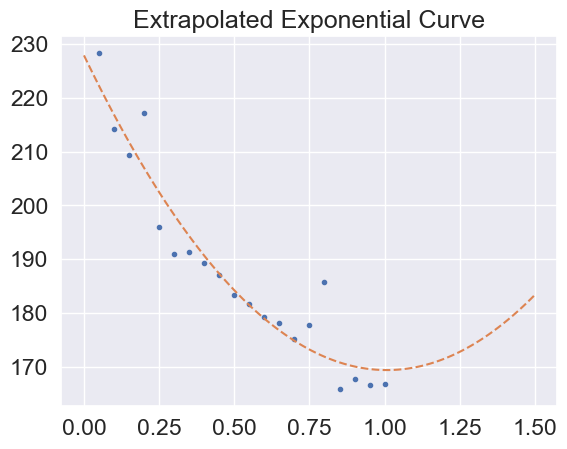

In [148]:
xs2 = np.linspace(0,1.5,100)
ys2 = monoExp(xs2, m, t, b)

plt.plot(xs, ys, '.', label="data")
plt.plot(xs2, ys2, '--', label="fitted")
plt.title("Extrapolated Exponential Curve")

In [152]:
xs

[0.05,
 0.1,
 0.15000000000000002,
 0.2,
 0.25,
 0.30000000000000004,
 0.35000000000000003,
 0.4,
 0.45,
 0.5,
 0.55,
 0.6000000000000001,
 0.65,
 0.7000000000000001,
 0.75,
 0.8,
 0.8500000000000001,
 0.9,
 0.9500000000000001,
 1.0]

In [154]:
[float(y) for y in ys]

[228.36025240384615,
 214.21509134615386,
 209.44737740384616,
 217.1388341346154,
 196.07176682692307,
 190.94765985576922,
 191.42037860576923,
 189.3363016826923,
 186.99302043269228,
 183.4424266826923,
 181.7485012019231,
 179.24636778846155,
 178.16944230769232,
 175.08142187500002,
 177.7435540865385,
 185.83584374999998,
 165.86741826923077,
 167.6642920673077,
 166.55420312500002,
 166.78160697115382]

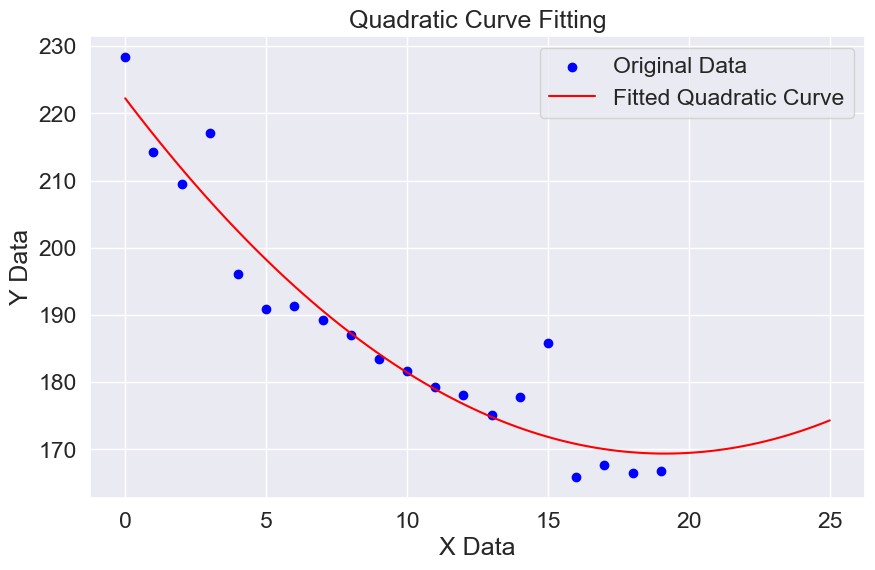

In [158]:
import numpy as np
import matplotlib.pyplot as plt

# The provided data
y_data = np.array([228.36025240384615, 214.21509134615386, 209.44737740384616, 217.1388341346154,
                   196.07176682692307, 190.94765985576922, 191.42037860576923, 189.3363016826923,
                   186.99302043269228, 183.4424266826923, 181.7485012019231, 179.24636778846155,
                   178.16944230769232, 175.08142187500002, 177.7435540865385, 185.83584374999998,
                   165.86741826923077, 167.6642920673077, 166.55420312500002, 166.78160697115382])
x_data = np.arange(len(y_data))

# Fit a quadratic curve (polynomial of degree 2)
coefficients = np.polyfit(x_data, y_data, 2)

# Generate a quadratic function using the fitted coefficients
def quadratic_function(x):
    a, b, c = coefficients
    return a * x**2 + b * x + c

# Generate y values from the fitted curve
x_data_2 = np.linspace(0,25,100)
fitted_y = quadratic_function(x_data_2)

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(x_data, y_data, label='Original Data', color='blue')
plt.plot(x_data_2, fitted_y, label='Fitted Quadratic Curve', color='red')
plt.title('Quadratic Curve Fitting')
plt.xlabel('X Data')
plt.ylabel('Y Data')
plt.legend()
plt.grid(True)
plt.show()